# Hidden Markov Model for Human Activity Recognition

## Project Overview
This notebook implements a Hidden Markov Model (HMM) to classify human activities (Standing, Walking, Still) using accelerometer and gyroscope data collected from smartphone sensors.

**Group Members:** Alain Michael Muhirwa, Joan Keza  
**Phone Models:** [Add phone models used]  
**Sampling Rates:** 100 HZ

In [47]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Data Collection and Loading

### Data Structure
- **Activities:** Standing, Still, Walking
- **Sensors:** Accelerometer (x, y, z), Gyroscope (x, y, z)
- **Format:** CSV files with columns: time, seconds_elapsed, z, y, x

In [48]:
# Data Loading Function
def load_sensor_data(base_path, person='Michael', activities=['Standing', 'Still', 'Walking', 'Jumping'], save_combined=True):
    """
    Load accelerometer and gyroscope data for all activities.
    Automatically detects and loads all sensor files (Accelerometer_1.csv, Accelerometer_2.csv, etc.)
    
    Parameters:
    -----------
    base_path : str
        Base path to data directory
    person : str
        Person's name (folder name)
    activities : list
        List of activity names
    save_combined : bool
        Whether to save combined data to CSV files
        
    Returns:
    --------
    dict : Dictionary containing DataFrames for each activity and sensor type
    """
    data = {}
    base = Path(base_path)
    
    # Create combined_data directory if saving
    if save_combined:
        combined_dir = base / 'combined_data'
        combined_dir.mkdir(exist_ok=True)
        print(f"Combined data will be saved to: {combined_dir}\n")
    
    for activity in activities:
        data[activity] = {}
        print(f"\n{'='*60}")
        print(f"Loading data for: {activity}")
        print('='*60)
        
        # Load all Accelerometer files
        accel_files = list((base / person / activity).glob('Accelerometer*.csv'))
        if accel_files:
            accel_dataframes = []
            for accel_file in sorted(accel_files):
                df = pd.read_csv(accel_file)
                df['sensor'] = 'accelerometer'
                df['activity'] = activity
                df['file_source'] = accel_file.name
                accel_dataframes.append(df)
                print(f"✓ Loaded {accel_file.name}: {len(df)} samples")
            
            # Combine all accelerometer data
            df_accel_combined = pd.concat(accel_dataframes, ignore_index=True)
            data[activity]['accelerometer'] = df_accel_combined
            print(f"  → Combined Accelerometer: {len(df_accel_combined)} total samples from {len(accel_files)} files")
            
            # Save combined accelerometer data
            if save_combined:
                combined_file = combined_dir / f'{person}_{activity}_Accelerometer_Combined.csv'
                df_accel_combined.to_csv(combined_file, index=False)
                print(f"  → Saved to: {combined_file.name}")
        else:
            print(f"✗ No Accelerometer files found in {base / person / activity}")
        
        # Load all Gyroscope files
        gyro_files = list((base / person / activity).glob('Gyroscope*.csv'))
        if gyro_files:
            gyro_dataframes = []
            for gyro_file in sorted(gyro_files):
                df = pd.read_csv(gyro_file)
                df['sensor'] = 'gyroscope'
                df['activity'] = activity
                df['file_source'] = gyro_file.name
                gyro_dataframes.append(df)
                print(f"✓ Loaded {gyro_file.name}: {len(df)} samples")
            
            # Combine all gyroscope data
            df_gyro_combined = pd.concat(gyro_dataframes, ignore_index=True)
            data[activity]['gyroscope'] = df_gyro_combined
            print(f"  → Combined Gyroscope: {len(df_gyro_combined)} total samples from {len(gyro_files)} files")
            
            # Save combined gyroscope data
            if save_combined:
                combined_file = combined_dir / f'{person}_{activity}_Gyroscope_Combined.csv'
                df_gyro_combined.to_csv(combined_file, index=False)
                print(f"  → Saved to: {combined_file.name}")
        else:
            print(f"✗ No Gyroscope files found in {base / person / activity}")
    
    print("\n" + "="*60)
    print("DATA LOADING SUMMARY")
    print("="*60)
    total_samples = 0
    for activity in activities:
        activity_samples = 0
        if activity in data:
            if 'accelerometer' in data[activity]:
                activity_samples += len(data[activity]['accelerometer'])
            if 'gyroscope' in data[activity]:
                activity_samples += len(data[activity]['gyroscope'])
        print(f"{activity}: {activity_samples:,} samples")
        total_samples += activity_samples
    print(f"\nTotal samples loaded: {total_samples:,}")
    print("="*60)
    
    return data

# Load the data
data_path = './data'
# sensor_data = load_sensor_data(data_path, person='Michael', save_combined=True)

In [49]:
# Load and Combine Data from Multiple People
def load_multi_person_data(base_path, people=['Michael'], activities=['Standing', 'Still', 'Walking'], save_combined=True):
    """
    Load sensor data from multiple people and combine them.
    
    Parameters:
    -----------
    base_path : str
        Base path to data directory
    people : list
        List of people's names (folder names)
    activities : list
        List of activity names
    save_combined : bool
        Whether to save combined data to CSV files
        
    Returns:
    --------
    dict : Dictionary containing combined DataFrames for each activity and sensor type
    """
    combined_data = {activity: {'accelerometer': [], 'gyroscope': []} for activity in activities}
    
    # Load data for each person
    for person in people:
        print(f"\n{'#'*60}")
        print(f"# Loading data for: {person}")
        print(f"{'#'*60}")
        person_data = load_sensor_data(base_path, person=person, activities=activities, save_combined=False)
        
        # Combine with overall data
        for activity in activities:
            if activity in person_data:
                if 'accelerometer' in person_data[activity]:
                    df = person_data[activity]['accelerometer'].copy()
                    df['person'] = person
                    combined_data[activity]['accelerometer'].append(df)
                
                if 'gyroscope' in person_data[activity]:
                    df = person_data[activity]['gyroscope'].copy()
                    df['person'] = person
                    combined_data[activity]['gyroscope'].append(df)
    
    # Concatenate all data
    final_data = {}
    base = Path(base_path)
    if save_combined:
        combined_dir = base / 'combined_data' / 'multi_person'
        combined_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"\n{'='*60}")
    print("COMBINING DATA FROM ALL PEOPLE")
    print('='*60)
    
    for activity in activities:
        final_data[activity] = {}
        
        if combined_data[activity]['accelerometer']:
            df_accel = pd.concat(combined_data[activity]['accelerometer'], ignore_index=True)
            final_data[activity]['accelerometer'] = df_accel
            print(f"\n{activity} - Accelerometer:")
            print(f"  Total samples: {len(df_accel):,}")
            print(f"  People: {df_accel['person'].unique().tolist()}")
            
            if save_combined:
                combined_file = combined_dir / f'All_People_{activity}_Accelerometer_Combined.csv'
                df_accel.to_csv(combined_file, index=False)
                print(f"  Saved to: {combined_file}")
        
        if combined_data[activity]['gyroscope']:
            df_gyro = pd.concat(combined_data[activity]['gyroscope'], ignore_index=True)
            final_data[activity]['gyroscope'] = df_gyro
            print(f"\n{activity} - Gyroscope:")
            print(f"  Total samples: {len(df_gyro):,}")
            print(f"  People: {df_gyro['person'].unique().tolist()}")
            
            if save_combined:
                combined_file = combined_dir / f'All_People_{activity}_Gyroscope_Combined.csv'
                df_gyro.to_csv(combined_file, index=False)
                print(f"  Saved to: {combined_file}")
    
    return final_data

sensor_data = load_multi_person_data(
    data_path, 
    people=['Michael', 'Joan'],
    activities=['Standing', 'Still', 'Walking', 'Jumping'],
    save_combined=True
)


############################################################
# Loading data for: Michael
############################################################

Loading data for: Standing
✓ Loaded Accelerometer_1.csv: 571 samples
✓ Loaded Accelerometer_2.csv: 566 samples
✓ Loaded Accelerometer_3.csv: 554 samples
✓ Loaded Accelerometer_4.csv: 492 samples
✓ Loaded Accelerometer_5.csv: 558 samples
✓ Loaded Accelerometer_6.csv: 550 samples
  → Combined Accelerometer: 3291 total samples from 6 files
✓ Loaded Gyroscope_1.csv: 576 samples
✓ Loaded Gyroscope_2.csv: 570 samples
✓ Loaded Gyroscope_3.csv: 558 samples
✓ Loaded Gyroscope_4.csv: 496 samples
✓ Loaded Gyroscope_5.csv: 561 samples
✓ Loaded Gyroscope_6.csv: 554 samples
  → Combined Gyroscope: 3315 total samples from 6 files

Loading data for: Still
✓ Loaded Accelerometer_1.csv: 596 samples
✓ Loaded Accelerometer_2.csv: 534 samples
✓ Loaded Accelerometer_3.csv: 622 samples
✓ Loaded Accelerometer_4.csv: 603 samples
✓ Loaded Accelerometer_5.csv: 56

In [50]:
from pathlib import Path

# Define the base data path
base_path = Path('data')

people = ['Joan', 'Michael']

combined_files = 0

# Loop over each person and list all files
for person in people:
    person_path = base_path / person
    print(f"\n{'='*60}")
    print(f"Files under: {person_path}")
    print('='*60)
    
    all_files = list(person_path.rglob('*'))

    combined_files += len(all_files)
    
    if all_files:
        print(f"\nTotal files found for {person}: {len(all_files)}")
    else:
        print("No files found.")

print(f"\nCombined total files from all people: {combined_files} which is {combined_files / 2} recordings/samples")


Files under: data\Joan

Total files found for Joan: 52

Files under: data\Michael

Total files found for Michael: 54

Combined total files from all people: 106 which is 53.0 recordings/samples


In [51]:
# Data Collection Summary Report
print("\n" + "="*80)
print("DATA COLLECTION SUMMARY REPORT")
print("="*80)

window_size = 100
overlap = 0.5

total_files = 0
activity_stats = {}

for activity in sensor_data.keys():
    activity_files = 0
    activity_duration = 0
    sampling_rates = {}
    
    for sensor_type in ['accelerometer', 'gyroscope']:
        if sensor_type in sensor_data[activity]:
            df = sensor_data[activity][sensor_type]
            
            # Count files
            if 'file_source' in df.columns:
                n_files = df['file_source'].nunique()
                activity_files += n_files
                total_files += n_files
            
            # Calculate duration
            if 'seconds_elapsed' in df.columns and len(df) > 1:
                duration = df['seconds_elapsed'].max() - df['seconds_elapsed'].min()
                activity_duration = max(activity_duration, duration)
            
            # Calculate sampling rate
            if len(df) > 1:
                time_diff = df['seconds_elapsed'].diff().median()
                sr = 1 / time_diff if time_diff > 0 else 100
                sampling_rates[sensor_type] = sr
    
    activity_stats[activity] = {
        'files': activity_files,
        'duration': activity_duration,
        'sampling_rates': sampling_rates
    }

print(f"\nTotal Files Collected: {total_files}")
print(f"Requirement: ≥50 files {'MET' if total_files >= 50 else 'NOT MET'}")

print("\n" + "-"*80)
print("Per-Activity Breakdown:")
print("-"*80)

for activity, stats in activity_stats.items():
    print(f"\n{activity}:")
    print(f"  Number of files: {stats['files']}")
    print(f"  Total duration: {stats['duration']:.2f} seconds ({stats['duration']/60:.2f} minutes)")
    print(f"Minimum duration (90s): {'MET' if stats['duration'] >= 90 else 'NOT MET'}")
    
    if stats['sampling_rates']:
        print(f"  Sampling rates:")
        for sensor, sr in stats['sampling_rates'].items():
            print(f"    - {sensor}: {sr:.2f} Hz")

print("\n" + "="*80)
print("SAMPLING RATE ANALYSIS & WINDOW SIZE JUSTIFICATION")
print("="*80)

# Calculate average sampling rate across all data
all_sampling_rates = []
for activity in sensor_data.keys():
    for sensor_type in ['accelerometer', 'gyroscope']:
        if sensor_type in sensor_data[activity]:
            df = sensor_data[activity][sensor_type]
            if len(df) > 1:
                time_diff = df['seconds_elapsed'].diff().median()
                sr = 1 / time_diff if time_diff > 0 else 100
                all_sampling_rates.append(sr)

avg_sampling_rate = np.mean(all_sampling_rates)
min_sampling_rate = np.min(all_sampling_rates)
max_sampling_rate = np.max(all_sampling_rates)

print(f"\nSampling Rate Statistics:")
print(f"  Average: {avg_sampling_rate:.2f} Hz")
print(f"  Minimum: {min_sampling_rate:.2f} Hz")
print(f"  Maximum: {max_sampling_rate:.2f} Hz")
print(f"  Range: {max_sampling_rate - min_sampling_rate:.2f} Hz")

print(f"\nWindow Size Selection:")
print(f"  Selected window size: {window_size} samples")
print(f"  Time window at avg sampling rate: {window_size/avg_sampling_rate:.2f} seconds")
print(f"  Overlap: {overlap*100:.0f}%")
print(f"  Effective step size: {int(window_size * (1-overlap))} samples")

print(f"\nJustification:")
print(f"  - Window size of {window_size} samples provides {window_size/avg_sampling_rate:.1f}s of data")
print(f"  - This captures sufficient temporal context for activity patterns")
print(f"  - At {avg_sampling_rate:.0f} Hz, this is adequate for human motion (typically <10 Hz)")
print(f"  - 50% overlap ensures we don't miss transitions between activities")
print(f"  - Window is large enough for reliable FFT analysis (frequency resolution)")

print(f"\nHandling Different Sampling Rates:")
print(f"  - Each window's sampling rate is calculated dynamically")
print(f"  - FFT frequency bins are adjusted based on actual sampling rate")
print(f"  - Feature normalization (Z-score) handles magnitude differences")
print(f"  - Fixed window size (samples) adapts to time duration based on rate")

print("="*80)


DATA COLLECTION SUMMARY REPORT

Total Files Collected: 98
Requirement: ≥50 files MET

--------------------------------------------------------------------------------
Per-Activity Breakdown:
--------------------------------------------------------------------------------

Standing:
  Number of files: 24
  Total duration: 10.52 seconds (0.18 minutes)
Minimum duration (90s): NOT MET
  Sampling rates:
    - accelerometer: 99.86 Hz
    - gyroscope: 99.86 Hz

Still:
  Number of files: 24
  Total duration: 10.61 seconds (0.18 minutes)
Minimum duration (90s): NOT MET
  Sampling rates:
    - accelerometer: 99.87 Hz
    - gyroscope: 99.87 Hz

Walking:
  Number of files: 26
  Total duration: 10.86 seconds (0.18 minutes)
Minimum duration (90s): NOT MET
  Sampling rates:
    - accelerometer: 99.87 Hz
    - gyroscope: 99.87 Hz

Jumping:
  Number of files: 24
  Total duration: 10.37 seconds (0.17 minutes)
Minimum duration (90s): NOT MET
  Sampling rates:
    - accelerometer: 99.87 Hz
    - gyroscop

In [52]:
# Display Detailed Data Information

print("="*80)
print("DETAILED DATA INFORMATION")
print("="*80)

for activity in sensor_data.keys():
    print(f"\n{activity.upper()}")
    print("-"*80)
    
    for sensor_type in ['accelerometer', 'gyroscope']:
        if sensor_type in sensor_data[activity]:
            df = sensor_data[activity][sensor_type]
            
            print(f"\n  {sensor_type.capitalize()}:")
            print(f"    Total samples: {len(df):,}")
            
            # Check if data has file_source column (multiple files loaded)
            if 'file_source' in df.columns:
                file_counts = df['file_source'].value_counts()
                print(f"    Number of files: {len(file_counts)}")
                print(f"    Files:")
                for file_name, count in file_counts.items():
                    print(f"      - {file_name}: {count:,} samples")
            
            # Check if data has person column (multiple people)
            if 'person' in df.columns:
                person_counts = df['person'].value_counts()
                print(f"    Number of people: {len(person_counts)}")
                for person, count in person_counts.items():
                    print(f"      - {person}: {count:,} samples")
            
            # Calculate duration
            if 'seconds_elapsed' in df.columns and len(df) > 1:
                duration = df['seconds_elapsed'].max() - df['seconds_elapsed'].min()
                print(f"    Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
            
            # Show column names
            print(f"    Columns: {df.columns.tolist()}")
            
            # Show first few rows
            print(f"\n    Sample data (first 3 rows):")
            print(df[['seconds_elapsed', 'x', 'y', 'z']].head(3).to_string(index=False))

print("\n" + "="*80)

DETAILED DATA INFORMATION

STANDING
--------------------------------------------------------------------------------

  Accelerometer:
    Total samples: 8,451
    Number of files: 12
    Files:
      - Accelerometer6.csv: 1,046 samples
      - Accelerometer2.csv: 996 samples
      - Accelerometer4.csv: 977 samples
      - Accelerometer1.csv: 861 samples
      - Accelerometer5.csv: 687 samples
      - Accelerometer3.csv: 593 samples
      - Accelerometer_1.csv: 571 samples
      - Accelerometer_2.csv: 566 samples
      - Accelerometer_5.csv: 558 samples
      - Accelerometer_3.csv: 554 samples
      - Accelerometer_6.csv: 550 samples
      - Accelerometer_4.csv: 492 samples
    Number of people: 2
      - Joan: 5,160 samples
      - Michael: 3,291 samples
    Duration: 10.52 seconds (0.18 minutes)
    Columns: ['time', 'seconds_elapsed', 'z', 'y', 'x', 'sensor', 'activity', 'file_source', 'person']

    Sample data (first 3 rows):
 seconds_elapsed        x        y         z
        0.


Activity: Standing


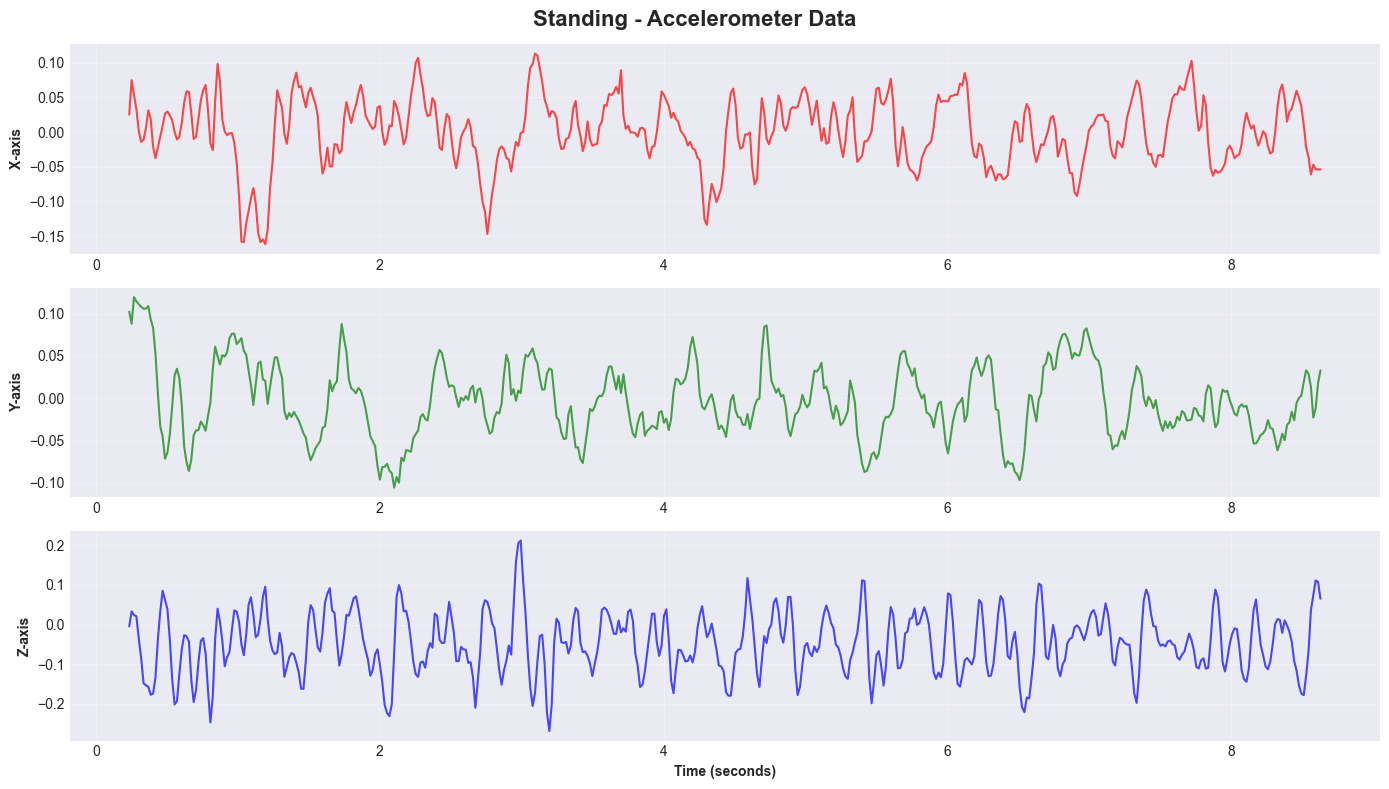

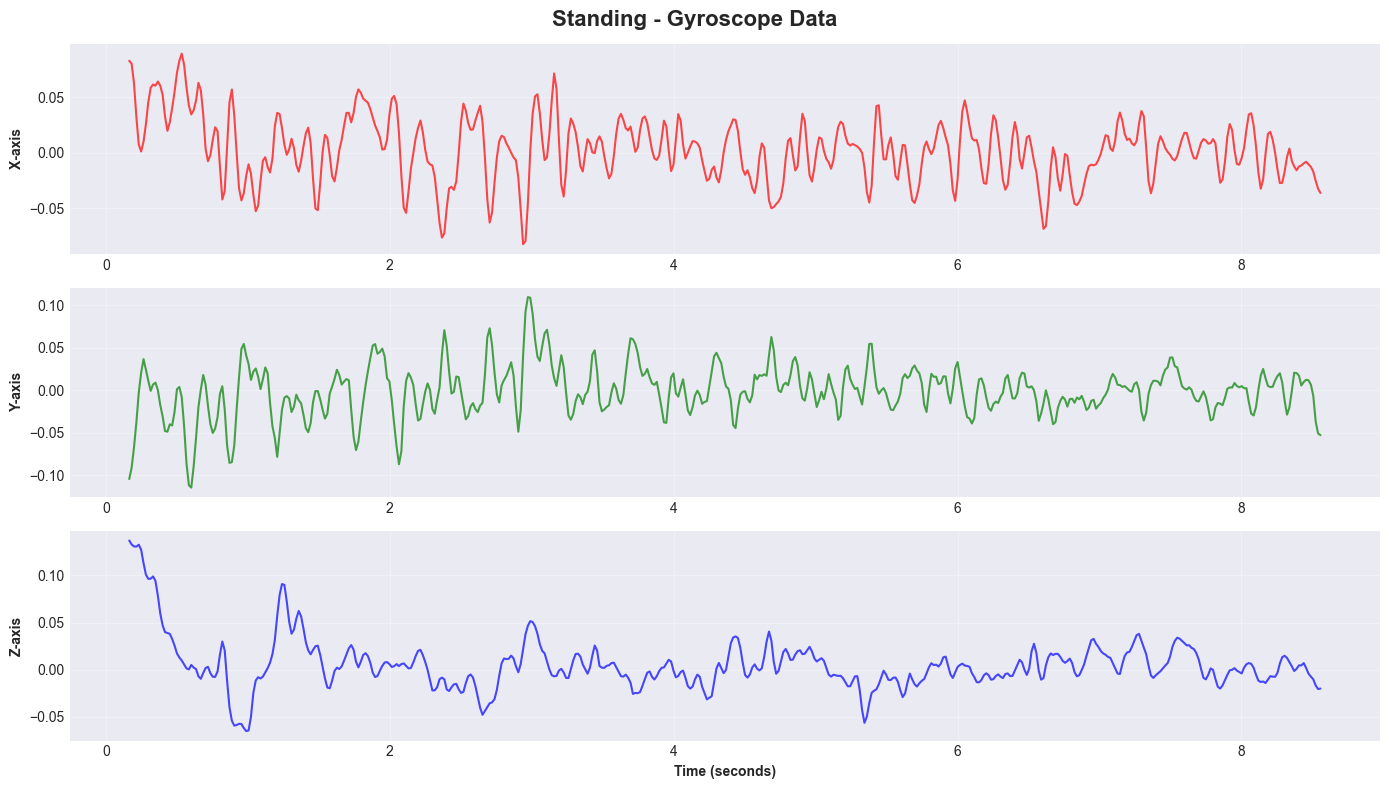


Activity: Still


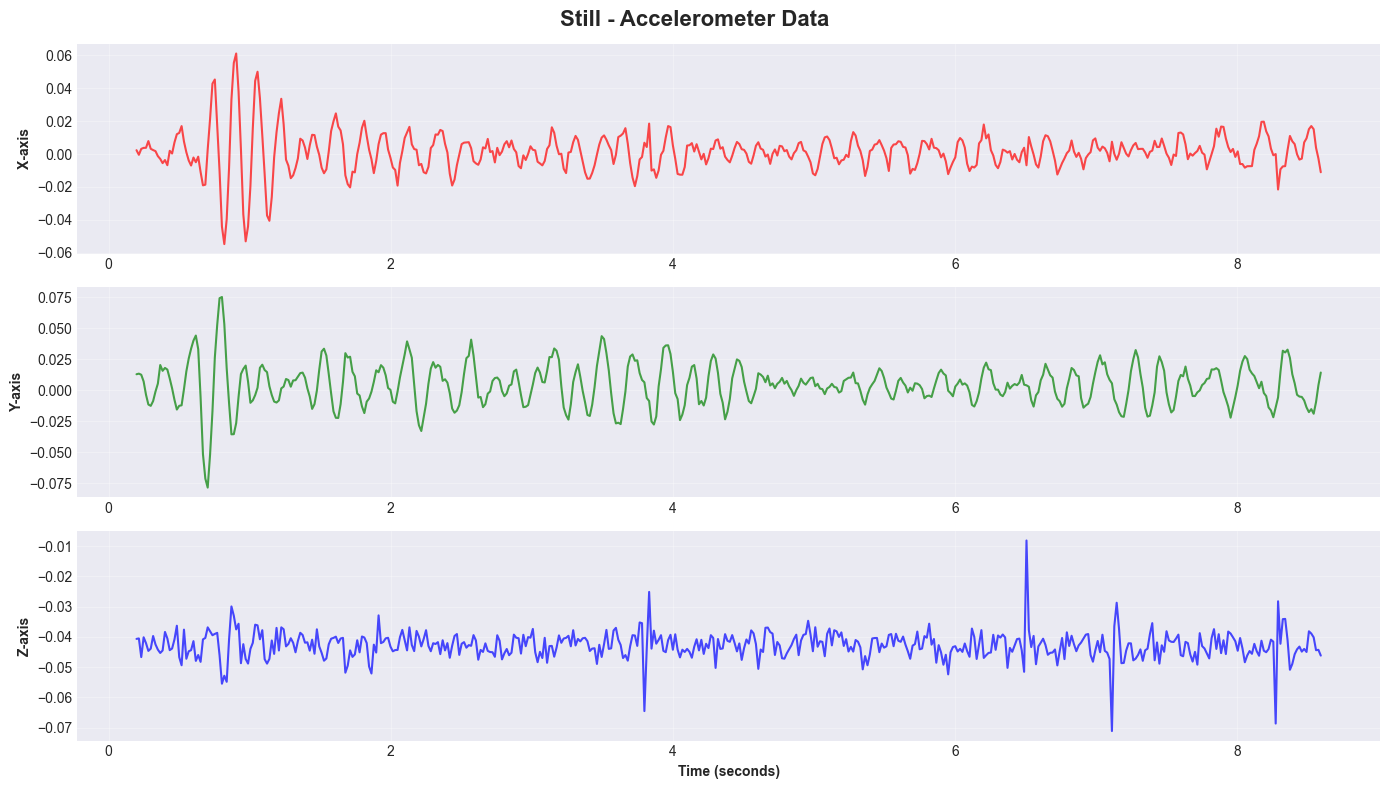

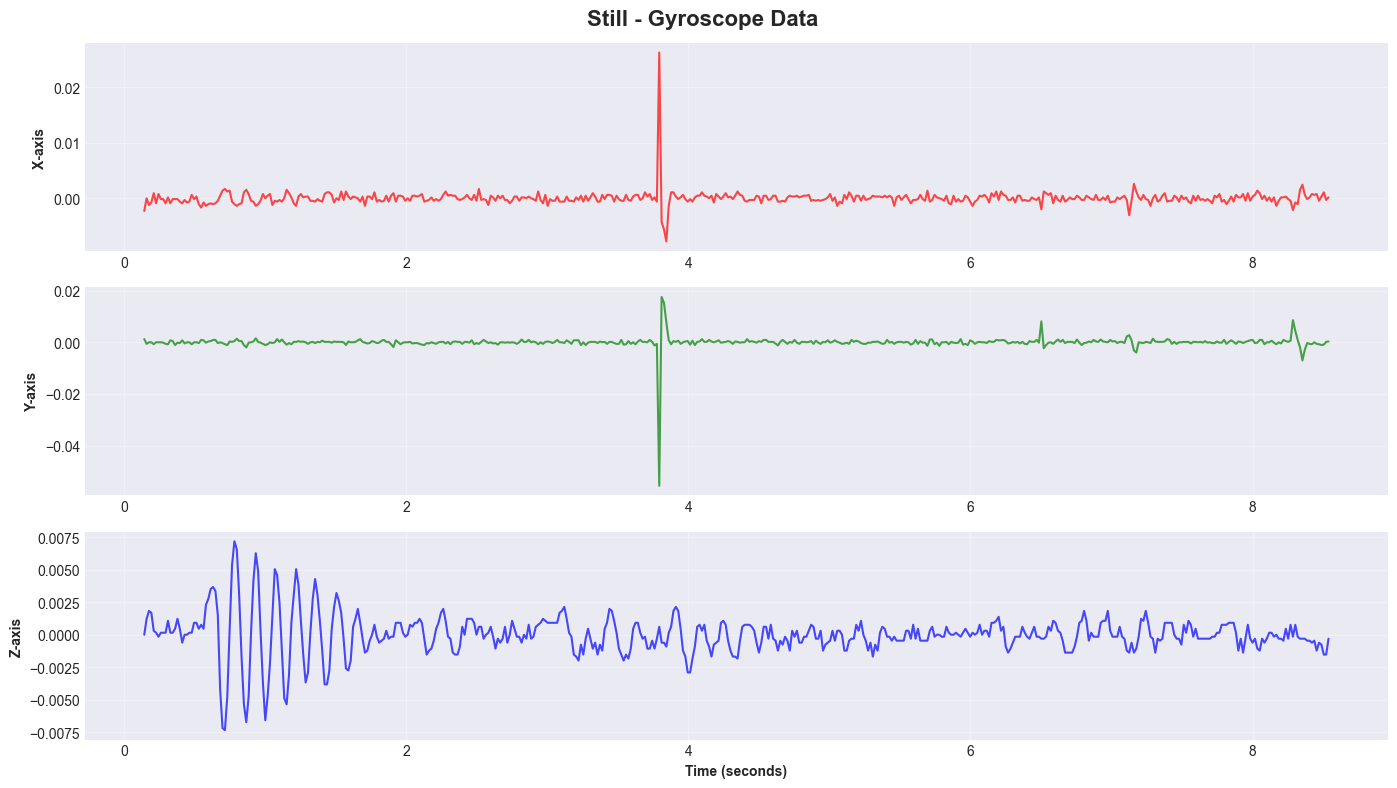


Activity: Walking


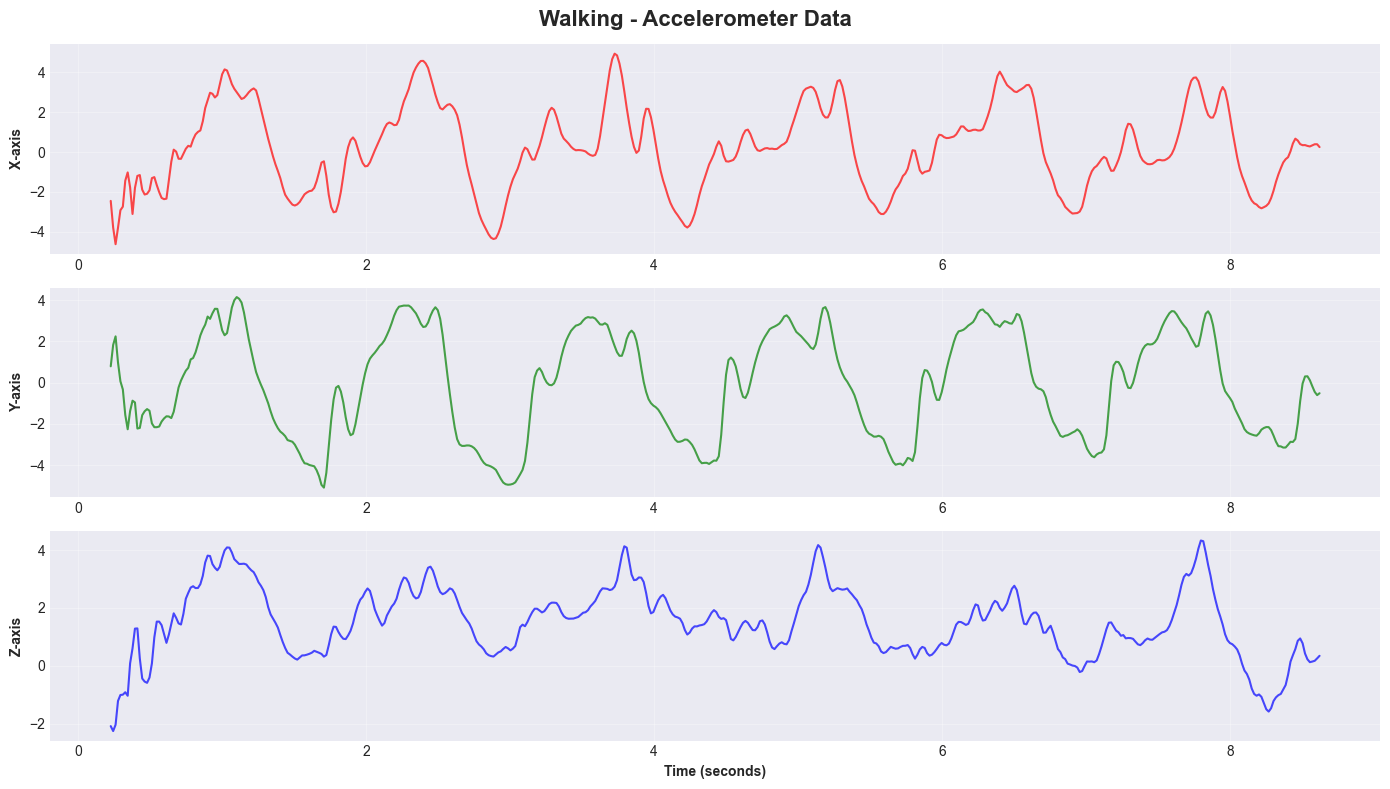

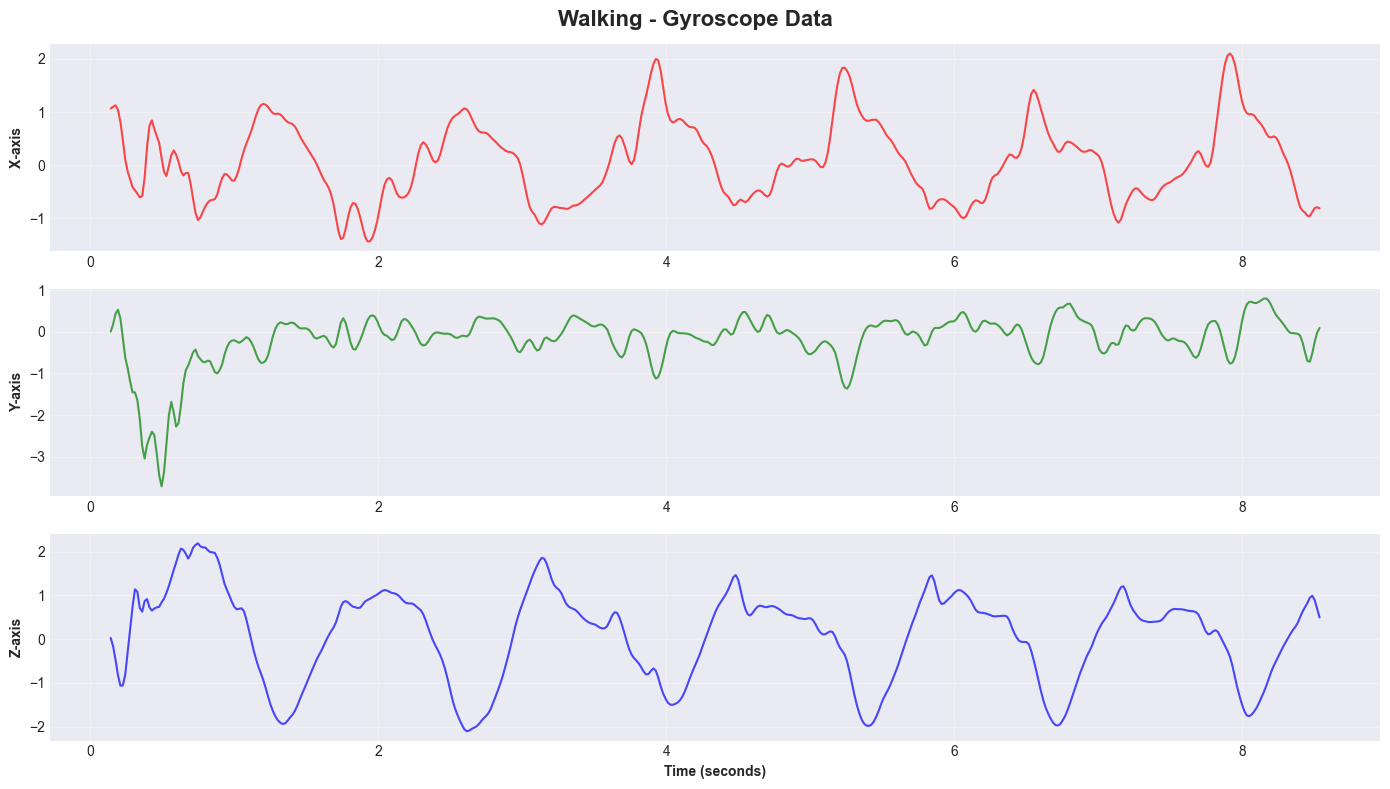

In [53]:
# Visualize Sample Data
def visualize_sensor_data(data, activity, sensor_type, sample_size=500):
    """Visualize raw sensor data for a given activity."""
    if activity in data and sensor_type in data[activity]:
        df = data[activity][sensor_type].head(sample_size)
        
        fig, axes = plt.subplots(3, 1, figsize=(14, 8))
        fig.suptitle(f'{activity} - {sensor_type.capitalize()} Data', fontsize=16, fontweight='bold')
        
        axes[0].plot(df['seconds_elapsed'], df['x'], color='red', alpha=0.7)
        axes[0].set_ylabel('X-axis', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(df['seconds_elapsed'], df['y'], color='green', alpha=0.7)
        axes[1].set_ylabel('Y-axis', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        axes[2].plot(df['seconds_elapsed'], df['z'], color='blue', alpha=0.7)
        axes[2].set_ylabel('Z-axis', fontweight='bold')
        axes[2].set_xlabel('Time (seconds)', fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Visualize all activities
for activity in ['Standing', 'Still', 'Walking']:
    print(f"\n{'='*60}")
    print(f"Activity: {activity}")
    print('='*60)
    visualize_sensor_data(sensor_data, activity, 'accelerometer')
    visualize_sensor_data(sensor_data, activity, 'gyroscope')

## 2. Feature Extraction

### Time-Domain Features:
1. **Mean** - Average value of signal
2. **Standard Deviation** - Measure of signal variability
3. **RMS (Root Mean Square)** - Energy content of signal
4. **Signal Magnitude Area (SMA)** - Overall intensity of movement
5. **Correlation between axes** - Relationship between x, y, z movements

### Frequency-Domain Features:
1. **Dominant Frequency** - Main frequency component via FFT
2. **Spectral Energy** - Total energy in frequency domain
3. **Spectral Entropy** - Measure of signal complexity

### Windowing Strategy:
- Window size will be determined based on sampling rate
- Overlapping windows for better temporal resolution

In [54]:
# Feature Extraction Functions

def calculate_time_domain_features(window_data):
    """
    Calculate time-domain features from a window of sensor data.
    
    Parameters:
    -----------
    window_data : DataFrame
        Window of sensor data with columns x, y, z
        
    Returns:
    --------
    dict : Dictionary of time-domain features
    """
    features = {}
    
    # Mean for each axis
    features['mean_x'] = window_data['x'].mean()
    features['mean_y'] = window_data['y'].mean()
    features['mean_z'] = window_data['z'].mean()
    
    # Standard deviation for each axis
    features['std_x'] = window_data['x'].std()
    features['std_y'] = window_data['y'].std()
    features['std_z'] = window_data['z'].std()
    
    # RMS (Root Mean Square) - energy content
    features['rms_x'] = np.sqrt(np.mean(window_data['x']**2))
    features['rms_y'] = np.sqrt(np.mean(window_data['y']**2))
    features['rms_z'] = np.sqrt(np.mean(window_data['z']**2))
    
    # Signal Magnitude Area (SMA) - overall intensity
    features['sma'] = (np.abs(window_data['x']).sum() + 
                       np.abs(window_data['y']).sum() + 
                       np.abs(window_data['z']).sum()) / len(window_data)
    
    # Correlation between axes
    try:
        features['corr_xy'] = window_data[['x', 'y']].corr().iloc[0, 1]
        features['corr_xz'] = window_data[['x', 'z']].corr().iloc[0, 1]
        features['corr_yz'] = window_data[['y', 'z']].corr().iloc[0, 1]
    except:
        features['corr_xy'] = 0
        features['corr_xz'] = 0
        features['corr_yz'] = 0
    
    # Magnitude
    features['magnitude_mean'] = np.sqrt(window_data['x']**2 + 
                                         window_data['y']**2 + 
                                         window_data['z']**2).mean()
    
    return features


def calculate_frequency_domain_features(window_data, sampling_rate=100):
    """
    Calculate frequency-domain features using FFT.
    
    Parameters:
    -----------
    window_data : DataFrame
        Window of sensor data with columns x, y, z
    sampling_rate : float
        Sampling rate in Hz
        
    Returns:
    --------
    dict : Dictionary of frequency-domain features
    """
    features = {}
    
    for axis in ['x', 'y', 'z']:
        signal = window_data[axis].values
        n = len(signal)
        
        if n < 2:
            features[f'dom_freq_{axis}'] = 0
            features[f'spectral_energy_{axis}'] = 0
            continue
        
        # Compute FFT
        fft_vals = fft(signal)
        fft_mag = np.abs(fft_vals[:n//2])
        freqs = fftfreq(n, 1/sampling_rate)[:n//2]
        
        # Dominant frequency
        if len(fft_mag) > 0:
            dom_freq_idx = np.argmax(fft_mag)
            features[f'dom_freq_{axis}'] = freqs[dom_freq_idx]
        else:
            features[f'dom_freq_{axis}'] = 0
        
        # Spectral energy
        features[f'spectral_energy_{axis}'] = np.sum(fft_mag**2)
        
        # Spectral entropy
        psd = fft_mag**2
        psd_norm = psd / (np.sum(psd) + 1e-10)
        features[f'spectral_entropy_{axis}'] = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))
    
    return features


def extract_features_from_window(window_data, sampling_rate=100):
    """
    Extract all features (time and frequency domain) from a window.
    
    Parameters:
    -----------
    window_data : DataFrame
        Window of sensor data
    sampling_rate : float
        Sampling rate in Hz
        
    Returns:
    --------
    dict : Dictionary of all features
    """
    features = {}
    
    # Time-domain features
    time_features = calculate_time_domain_features(window_data)
    features.update(time_features)
    
    # Frequency-domain features
    freq_features = calculate_frequency_domain_features(window_data, sampling_rate)
    features.update(freq_features)
    
    return features

print("✓ Feature extraction functions defined")

✓ Feature extraction functions defined


In [55]:
# Create Windows and Extract Features

def create_windows_and_extract_features(data, window_size=100, overlap=0.5):
    """
    Create overlapping windows and extract features for all activities.
    
    Parameters:
    -----------
    data : dict
        Dictionary containing sensor data for each activity
    window_size : int
        Number of samples per window
    overlap : float
        Overlap ratio (0-1)
        
    Returns:
    --------
    DataFrame : Feature matrix with labels
    """
    all_features = []
    step_size = int(window_size * (1 - overlap))
    
    for activity in data.keys():
        print(f"\nProcessing {activity}...")
        
        for sensor_type in ['accelerometer', 'gyroscope']:
            if sensor_type not in data[activity]:
                continue
            
            df = data[activity][sensor_type]
            print(f"  {sensor_type}: {len(df)} samples")
            
            # Determine sampling rate
            if len(df) > 1:
                time_diff = df['seconds_elapsed'].diff().median()
                sampling_rate = 1 / time_diff if time_diff > 0 else 100
            else:
                sampling_rate = 100
            
            # Create windows
            num_windows = (len(df) - window_size) // step_size + 1
            
            for i in range(num_windows):
                start_idx = i * step_size
                end_idx = start_idx + window_size
                
                if end_idx > len(df):
                    break
                
                window = df.iloc[start_idx:end_idx]
                
                # Extract features
                features = extract_features_from_window(window, sampling_rate)
                features['activity'] = activity
                features['sensor'] = sensor_type
                features['window_id'] = i
                
                all_features.append(features)
            
            print(f"    Created {num_windows} windows")
    
    # Convert to DataFrame
    feature_df = pd.DataFrame(all_features)
    print(f"\n✓ Total feature vectors: {len(feature_df)}")
    print(f"✓ Features per vector: {len(feature_df.columns) - 3}")  # Exclude activity, sensor, window_id
    
    return feature_df

# Extract features with window size of 100 samples and 50% overlap
window_size = 100
overlap = 0.5
print(f"Window Configuration:")
print(f"  - Window size: {window_size} samples")
print(f"  - Overlap: {overlap*100}%")
print(f"  - Step size: {int(window_size * (1-overlap))} samples")

features_df = create_windows_and_extract_features(sensor_data, window_size, overlap)

Window Configuration:
  - Window size: 100 samples
  - Overlap: 50.0%
  - Step size: 50 samples

Processing Standing...
  accelerometer: 8451 samples
    Created 168 windows
  gyroscope: 8475 samples
    Created 168 windows
  gyroscope: 8475 samples
    Created 168 windows

Processing Still...
  accelerometer: 8912 samples
    Created 168 windows

Processing Still...
  accelerometer: 8912 samples
    Created 177 windows
  gyroscope: 8938 samples
    Created 177 windows
  gyroscope: 8938 samples
    Created 177 windows

Processing Walking...
  accelerometer: 9366 samples
    Created 177 windows

Processing Walking...
  accelerometer: 9366 samples
    Created 186 windows
  gyroscope: 9396 samples
    Created 186 windows
  gyroscope: 9396 samples
    Created 186 windows

Processing Jumping...
  accelerometer: 8608 samples
    Created 186 windows

Processing Jumping...
  accelerometer: 8608 samples
    Created 171 windows
  gyroscope: 8665 samples
    Created 171 windows
  gyroscope: 8665 

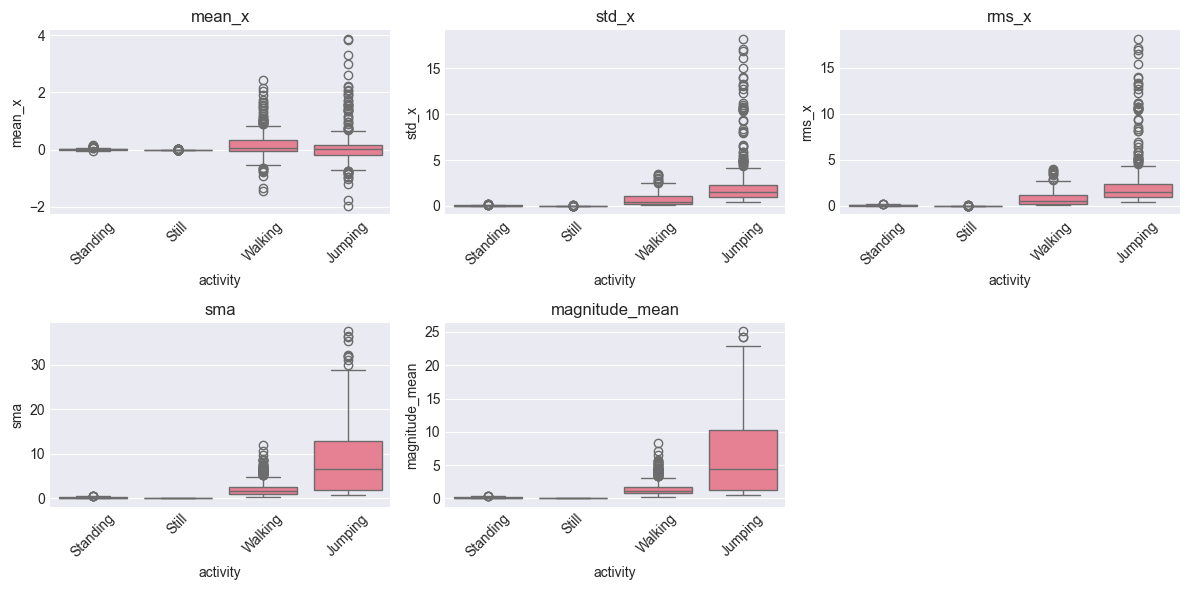

In [ ]:
selected_features = ['mean_x', 'std_x', 'rms_x', 'sma', 'magnitude_mean']

plt.figure(figsize=(12, 6))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=features_df, x='activity', y=feature)
    plt.title(feature)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
# Normalize Features

# Display feature summary
print("\nFeature DataFrame Info:")
print(f"Shape: {features_df.shape}")
print(f"\nActivities distribution:")
print(features_df['activity'].value_counts())
print(f"\nSensor distribution:")
print(features_df['sensor'].value_counts())

# Separate features and labels
feature_columns = [col for col in features_df.columns if col not in ['activity', 'sensor', 'window_id']]
X = features_df[feature_columns].values
y = features_df['activity'].values
sensor_types = features_df['sensor'].values

# Normalize features using Z-score normalization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

print(f"\n✓ Features normalized using Z-score standardization")
print(f"  Mean of normalized features: {X_normalized.mean():.6f}")
print(f"  Std of normalized features: {X_normalized.std():.6f}")

# Create normalized DataFrame for easier manipulation
features_normalized_df = pd.DataFrame(X_normalized, columns=feature_columns)
features_normalized_df['activity'] = y
features_normalized_df['sensor'] = sensor_types
features_normalized_df['window_id'] = features_df['window_id']

print(f"\n✓ Normalized feature matrix shape: {X_normalized.shape}")


Feature DataFrame Info:
Shape: (1405, 26)

Activities distribution:
Walking     372
Still       354
Jumping     343
Standing    336
Name: activity, dtype: int64

Sensor distribution:
gyroscope        703
accelerometer    702
Name: sensor, dtype: int64

✓ Features normalized using Z-score standardization
  Mean of normalized features: -0.000000
  Std of normalized features: 1.000000

✓ Normalized feature matrix shape: (1405, 23)


## 3. Hidden Markov Model Implementation

### HMM Components:
- **Hidden States (Z):** The underlying activities (Standing, Still, Walking)
- **Observations (X):** Feature vectors from accelerometer and gyroscope
- **Transition Probabilities (A):** P(state_t+1 | state_t)
- **Emission Probabilities (B):** P(observation | state)
- **Initial Probabilities (π):** P(state_0)

### Algorithms:
1. **Viterbi Algorithm:** Find the most likely sequence of states
2. **Baum-Welch Algorithm:** Train model parameters using EM algorithm

In [57]:
# Hidden Markov Model Implementation

class GaussianHMM:
    """
    Hidden Markov Model with Gaussian emissions.
    Implements Viterbi algorithm for decoding and Baum-Welch for training.
    """
    
    def __init__(self, n_states, n_features):
        """
        Initialize HMM.
        
        Parameters:
        -----------
        n_states : int
            Number of hidden states
        n_features : int
            Number of features in observations
        """
        self.n_states = n_states
        self.n_features = n_features
        
        # Initialize parameters randomly
        self.start_prob = np.ones(n_states) / n_states
        self.trans_prob = np.ones((n_states, n_states)) / n_states
        
        # Gaussian emission parameters (mean and covariance for each state)
        self.means = np.random.randn(n_states, n_features)
        self.covars = np.array([np.eye(n_features) for _ in range(n_states)])
        
        self.state_names = None
        
    def _gaussian_pdf(self, X, mean, covar):
        """
        Calculate multivariate Gaussian PDF.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Observations
        mean : array, shape (n_features,)
            Mean vector
        covar : array, shape (n_features, n_features)
            Covariance matrix
            
        Returns:
        --------
        array : PDF values for each sample
        """
        n = X.shape[1]
        diff = X - mean
        
        # Add regularization to covariance for numerical stability
        covar_reg = covar + np.eye(n) * 1e-6
        
        try:
            covar_inv = np.linalg.inv(covar_reg)
            covar_det = np.linalg.det(covar_reg)
        except:
            # If singular, use identity
            covar_inv = np.eye(n)
            covar_det = 1.0
        
        norm_const = 1.0 / (np.sqrt((2 * np.pi) ** n * np.abs(covar_det)))
        exponent = -0.5 * np.sum(diff @ covar_inv * diff, axis=1)
        
        return norm_const * np.exp(exponent)
    
    def _compute_emission_prob(self, X):
        """
        Compute emission probabilities for all states and observations.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Observations
            
        Returns:
        --------
        array, shape (n_samples, n_states) : Emission probabilities
        """
        n_samples = X.shape[0]
        emission_prob = np.zeros((n_samples, self.n_states))
        
        for state in range(self.n_states):
            emission_prob[:, state] = self._gaussian_pdf(X, self.means[state], self.covars[state])
        
        # Add small epsilon to avoid log(0)
        emission_prob = np.maximum(emission_prob, 1e-10)
        
        return emission_prob
    
    def viterbi(self, X):
        """
        Viterbi algorithm to find most likely state sequence.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Sequence of observations
            
        Returns:
        --------
        array : Most likely state sequence
        """
        n_samples = X.shape[0]
        
        # Compute emission probabilities
        emission_prob = self._compute_emission_prob(X)
        
        # Initialize
        viterbi_prob = np.zeros((n_samples, self.n_states))
        viterbi_path = np.zeros((n_samples, self.n_states), dtype=int)
        
        # Initial step
        viterbi_prob[0] = np.log(self.start_prob) + np.log(emission_prob[0])
        
        # Recursion
        for t in range(1, n_samples):
            for state in range(self.n_states):
                trans_probs = viterbi_prob[t-1] + np.log(self.trans_prob[:, state])
                viterbi_path[t, state] = np.argmax(trans_probs)
                viterbi_prob[t, state] = np.max(trans_probs) + np.log(emission_prob[t, state])
        
        # Backtrack
        states = np.zeros(n_samples, dtype=int)
        states[-1] = np.argmax(viterbi_prob[-1])
        
        for t in range(n_samples - 2, -1, -1):
            states[t] = viterbi_path[t + 1, states[t + 1]]
        
        return states
    
    def _forward(self, X):
        """
        Forward algorithm for computing forward probabilities.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Observations
            
        Returns:
        --------
        array, shape (n_samples, n_states) : Forward probabilities
        float : Log-likelihood
        """
        n_samples = X.shape[0]
        emission_prob = self._compute_emission_prob(X)
        
        # Initialize forward probabilities
        forward = np.zeros((n_samples, self.n_states))
        forward[0] = self.start_prob * emission_prob[0]
        
        # Scale factor for numerical stability
        scale = np.zeros(n_samples)
        scale[0] = np.sum(forward[0])
        forward[0] /= scale[0]
        
        # Forward recursion
        for t in range(1, n_samples):
            for state in range(self.n_states):
                forward[t, state] = np.sum(forward[t-1] * self.trans_prob[:, state]) * emission_prob[t, state]
            
            scale[t] = np.sum(forward[t])
            if scale[t] > 0:
                forward[t] /= scale[t]
        
        log_likelihood = np.sum(np.log(scale + 1e-10))
        
        return forward, log_likelihood
    
    def _backward(self, X, scale):
        """
        Backward algorithm for computing backward probabilities.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Observations
        scale : array
            Scaling factors from forward algorithm
            
        Returns:
        --------
        array, shape (n_samples, n_states) : Backward probabilities
        """
        n_samples = X.shape[0]
        emission_prob = self._compute_emission_prob(X)
        
        # Initialize backward probabilities
        backward = np.zeros((n_samples, self.n_states))
        backward[-1] = 1.0
        
        # Backward recursion
        for t in range(n_samples - 2, -1, -1):
            for state in range(self.n_states):
                backward[t, state] = np.sum(
                    self.trans_prob[state, :] * emission_prob[t+1] * backward[t+1]
                )
            
            if scale[t] > 0:
                backward[t] /= scale[t]
        
        return backward
    
    def baum_welch(self, X, n_iter=100, tol=1e-4, verbose=True):
        """
        Baum-Welch algorithm (EM) for training HMM parameters.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Training observations
        n_iter : int
            Maximum number of iterations
        tol : float
            Convergence tolerance
        verbose : bool
            Print progress
            
        Returns:
        --------
        list : Log-likelihoods per iteration
        """
        n_samples = X.shape[0]
        log_likelihoods = []
        
        for iteration in range(n_iter):
            # E-step: Forward-backward algorithm
            emission_prob = self._compute_emission_prob(X)
            
            # Forward pass
            forward = np.zeros((n_samples, self.n_states))
            forward[0] = self.start_prob * emission_prob[0]
            scale = np.zeros(n_samples)
            scale[0] = np.sum(forward[0])
            forward[0] /= scale[0]
            
            for t in range(1, n_samples):
                for state in range(self.n_states):
                    forward[t, state] = np.sum(forward[t-1] * self.trans_prob[:, state]) * emission_prob[t, state]
                scale[t] = np.sum(forward[t])
                if scale[t] > 0:
                    forward[t] /= scale[t]
            
            log_likelihood = np.sum(np.log(scale + 1e-10))
            log_likelihoods.append(log_likelihood)
            
            # Backward pass
            backward = self._backward(X, scale)
            
            # Compute gamma and xi
            gamma = forward * backward
            gamma /= np.sum(gamma, axis=1, keepdims=True)
            
            xi = np.zeros((n_samples - 1, self.n_states, self.n_states))
            for t in range(n_samples - 1):
                for i in range(self.n_states):
                    for j in range(self.n_states):
                        xi[t, i, j] = (forward[t, i] * self.trans_prob[i, j] * 
                                      emission_prob[t+1, j] * backward[t+1, j])
                xi[t] /= np.sum(xi[t])
            
            # M-step: Update parameters
            self.start_prob = gamma[0]
            
            for i in range(self.n_states):
                for j in range(self.n_states):
                    self.trans_prob[i, j] = np.sum(xi[:, i, j]) / np.sum(gamma[:-1, i])
            
            # Normalize transition probabilities
            self.trans_prob /= np.sum(self.trans_prob, axis=1, keepdims=True)
            
            # Update emission parameters (Gaussian means and covariances)
            for state in range(self.n_states):
                gamma_sum = np.sum(gamma[:, state])
                self.means[state] = np.sum(gamma[:, state].reshape(-1, 1) * X, axis=0) / gamma_sum
                
                diff = X - self.means[state]
                self.covars[state] = (gamma[:, state].reshape(-1, 1, 1) * 
                                     diff[:, :, np.newaxis] @ diff[:, np.newaxis, :]).sum(axis=0) / gamma_sum
            
            # Check convergence
            if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
                if verbose:
                    print(f"✓ Converged at iteration {iteration + 1}")
                break
            
            if verbose and (iteration + 1) % 10 == 0:
                print(f"  Iteration {iteration + 1}/{n_iter}, Log-Likelihood: {log_likelihood:.4f}")
        
        return log_likelihoods
    
    def fit(self, X, y, n_iter=100, tol=1e-4, verbose=True):
        """
        Fit HMM to labeled data to initialize parameters.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Training observations
        y : array, shape (n_samples,)
            State labels (for initialization)
        n_iter : int
            Maximum iterations for Baum-Welch
        tol : float
            Convergence tolerance
        verbose : bool
            Print progress
        """
        # Get unique states
        unique_states = np.unique(y)
        self.state_names = unique_states
        state_to_idx = {state: idx for idx, state in enumerate(unique_states)}
        y_idx = np.array([state_to_idx[state] for state in y])
        
        # Initialize start probabilities
        for idx in range(self.n_states):
            self.start_prob[idx] = np.mean(y_idx == idx)
        
        # Initialize transition probabilities
        for i in range(self.n_states):
            for j in range(self.n_states):
                transitions = np.sum((y_idx[:-1] == i) & (y_idx[1:] == j))
                total_from_i = np.sum(y_idx[:-1] == i)
                self.trans_prob[i, j] = (transitions + 1) / (total_from_i + self.n_states)  # Laplace smoothing
        
        # Initialize emission parameters from data
        for idx in range(self.n_states):
            state_data = X[y_idx == idx]
            if len(state_data) > 0:
                self.means[idx] = np.mean(state_data, axis=0)
                self.covars[idx] = np.cov(state_data.T) + np.eye(self.n_features) * 0.01
        
        if verbose:
            print("✓ Parameters initialized from labeled data")
            print(f"\nStarting Baum-Welch training...")
        
        # Train with Baum-Welch
        log_likelihoods = self.baum_welch(X, n_iter=n_iter, tol=tol, verbose=verbose)
        
        return log_likelihoods
    
    def predict(self, X):
        """
        Predict state sequence using Viterbi algorithm.
        
        Parameters:
        -----------
        X : array, shape (n_samples, n_features)
            Observations
            
        Returns:
        --------
        array : Predicted state sequence
        """
        state_idx = self.viterbi(X)
        
        if self.state_names is not None:
            return np.array([self.state_names[idx] for idx in state_idx])
        
        return state_idx

print("✓ GaussianHMM class defined")

✓ GaussianHMM class defined


In [58]:
# Prepare Training and Test Data

# Group data by activity and sensor to create sequences
def prepare_sequences(features_df, test_split=0.2):
    """
    Prepare training and test sequences maintaining temporal order.
    
    Parameters:
    -----------
    features_df : DataFrame
        Feature DataFrame with activity and sensor labels
    test_split : float
        Proportion of data to use for testing
        
    Returns:
    --------
    tuple : (X_train, y_train, X_test, y_test)
    """
    feature_cols = [col for col in features_df.columns if col not in ['activity', 'sensor', 'window_id']]
    
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []
    
    # For each activity and sensor, split temporally
    for activity in features_df['activity'].unique():
        for sensor in features_df['sensor'].unique():
            # Get data for this activity-sensor combination
            mask = (features_df['activity'] == activity) & (features_df['sensor'] == sensor)
            subset = features_df[mask].sort_values('window_id')
            
            if len(subset) == 0:
                continue
            
            # Split temporally (first 80% train, last 20% test)
            split_idx = int(len(subset) * (1 - test_split))
            
            train_subset = subset.iloc[:split_idx]
            test_subset = subset.iloc[split_idx:]
            
            if len(train_subset) > 0:
                X_train_list.append(train_subset[feature_cols].values)
                y_train_list.append(train_subset['activity'].values)
            
            if len(test_subset) > 0:
                X_test_list.append(test_subset[feature_cols].values)
                y_test_list.append(test_subset['activity'].values)
    
    # Concatenate all sequences
    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)
    
    return X_train, y_train, X_test, y_test

# Prepare data
X_train, y_train, X_test, y_test = prepare_sequences(features_normalized_df, test_split=0.2)

print("Data Split Summary:")
print("=" * 60)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nTraining set activity distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for activity, count in zip(unique, counts):
    print(f"  {activity}: {count} ({count/len(y_train)*100:.1f}%)")
print(f"\nTest set activity distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for activity, count in zip(unique, counts):
    print(f"  {activity}: {count} ({count/len(y_test)*100:.1f}%)")

Data Split Summary:
Training samples: 1119
Test samples: 286
Number of features: 23

Training set activity distribution:
  Jumping: 273 (24.4%)
  Standing: 268 (23.9%)
  Still: 282 (25.2%)
  Walking: 296 (26.5%)

Test set activity distribution:
  Jumping: 70 (24.5%)
  Standing: 68 (23.8%)
  Still: 72 (25.2%)
  Walking: 76 (26.6%)


In [59]:
# Train the HMM

# Get number of states and features
n_states = len(np.unique(y_train))
n_features = X_train.shape[1]

print(f"Initializing HMM:")
print(f"  Number of states: {n_states}")
print(f"  Number of features: {n_features}")
print()

# Create and train HMM
hmm = GaussianHMM(n_states=n_states, n_features=n_features)

# Train the model
log_likelihoods = hmm.fit(X_train, y_train, n_iter=100, tol=1e-4, verbose=True)

print("\n" + "=" * 60)
print("✓ Training completed!")
print("=" * 60)

Initializing HMM:
  Number of states: 4
  Number of features: 23

✓ Parameters initialized from labeled data

Starting Baum-Welch training...
  Iteration 10/100, Log-Likelihood: 32971.4549
  Iteration 20/100, Log-Likelihood: 32900.1932
  Iteration 30/100, Log-Likelihood: 32894.1655
✓ Converged at iteration 37

✓ Training completed!


In [60]:
# Enhanced Training Summary
print("\n" + "="*80)
print("TRAINING CONVERGENCE ANALYSIS")
print("="*80)

print(f"\nConvergence Settings:")
print(f"  - Convergence tolerance: {1e-4}")
print(f"  - Maximum iterations: 100")
print(f"  - Actual iterations completed: {len(log_likelihoods)}")

if len(log_likelihoods) > 1:
    final_improvement = abs(log_likelihoods[-1] - log_likelihoods[-2])
    print(f"  - Final log-likelihood improvement: {final_improvement:.6f}")
    print(f"  - Converged: {'Yes' if final_improvement < 1e-4 else 'No'}")
    print(f"\nLog-likelihood progression:")
    print(f"  - Initial: {log_likelihoods[0]:.4f}")
    print(f"  - Final: {log_likelihoods[-1]:.4f}")
    print(f"  - Total improvement: {log_likelihoods[-1] - log_likelihoods[0]:.4f}")

print("="*80)



TRAINING CONVERGENCE ANALYSIS

Convergence Settings:
  - Convergence tolerance: 0.0001
  - Maximum iterations: 100
  - Actual iterations completed: 37
  - Final log-likelihood improvement: 0.000072
  - Converged: Yes

Log-likelihood progression:
  - Initial: 3227.5779
  - Final: 32894.1573
  - Total improvement: 29666.5793


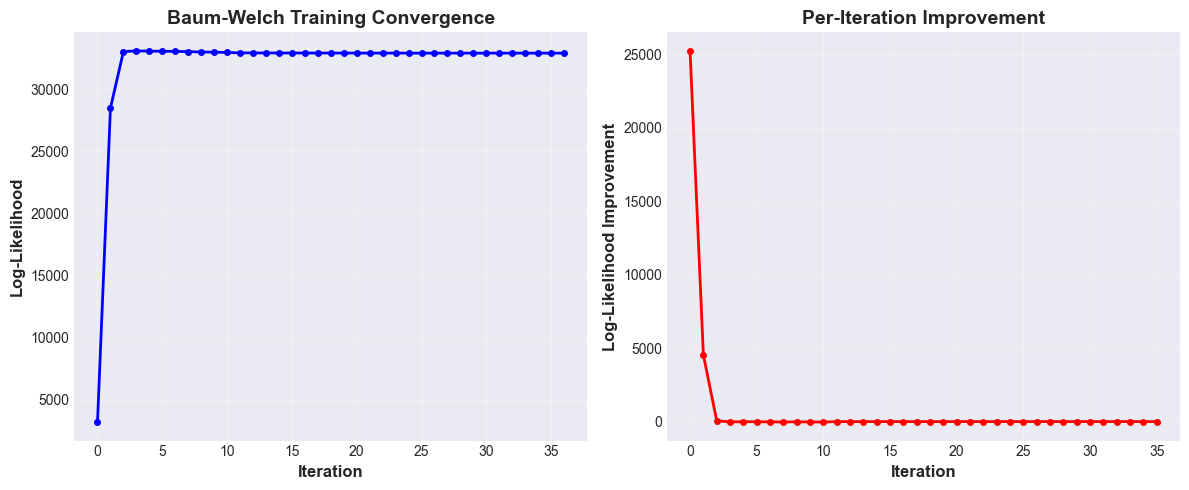

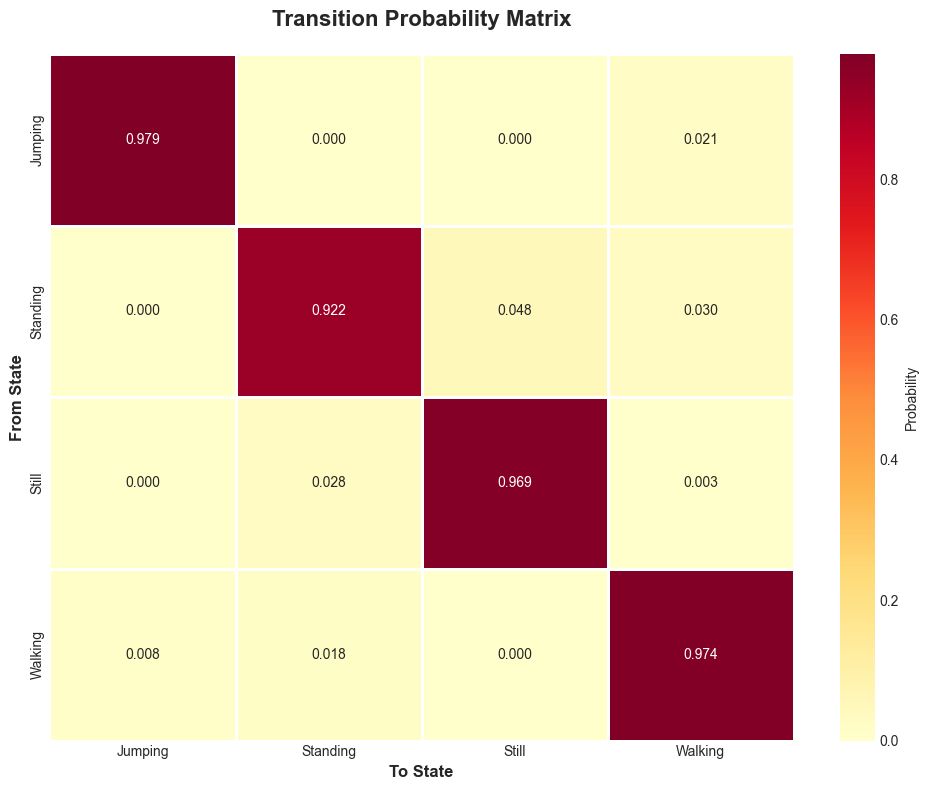

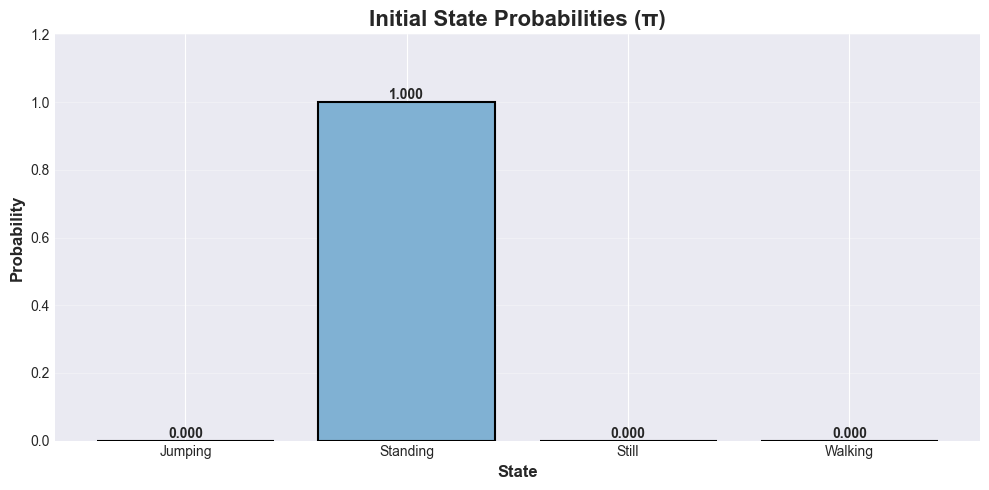


✓ HMM parameters visualized


In [61]:
# Visualize HMM Parameters

# Plot training convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(log_likelihoods, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Iteration', fontweight='bold', fontsize=12)
plt.ylabel('Log-Likelihood', fontweight='bold', fontsize=12)
plt.title('Baum-Welch Training Convergence', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if len(log_likelihoods) > 1:
    improvements = np.diff(log_likelihoods)
    plt.plot(improvements, 'r-', linewidth=2, marker='o', markersize=4)
    plt.xlabel('Iteration', fontweight='bold', fontsize=12)
    plt.ylabel('Log-Likelihood Improvement', fontweight='bold', fontsize=12)
    plt.title('Per-Iteration Improvement', fontweight='bold', fontsize=14)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize Transition Probability Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(hmm.trans_prob, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=hmm.state_names, yticklabels=hmm.state_names,
            cbar_kws={'label': 'Probability'}, linewidths=1, linecolor='white')
plt.title('Transition Probability Matrix', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('To State', fontweight='bold', fontsize=12)
plt.ylabel('From State', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()

# Visualize Initial State Probabilities
plt.figure(figsize=(10, 5))
colors = plt.cm.Set3(np.linspace(0, 1, len(hmm.state_names)))
bars = plt.bar(hmm.state_names, hmm.start_prob, color=colors, edgecolor='black', linewidth=1.5)
plt.ylabel('Probability', fontweight='bold', fontsize=12)
plt.xlabel('State', fontweight='bold', fontsize=12)
plt.title('Initial State Probabilities (π)', fontweight='bold', fontsize=16)
plt.ylim([0, max(hmm.start_prob) * 1.2])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n✓ HMM parameters visualized")


EMISSION PROBABILITY VISUALIZATION


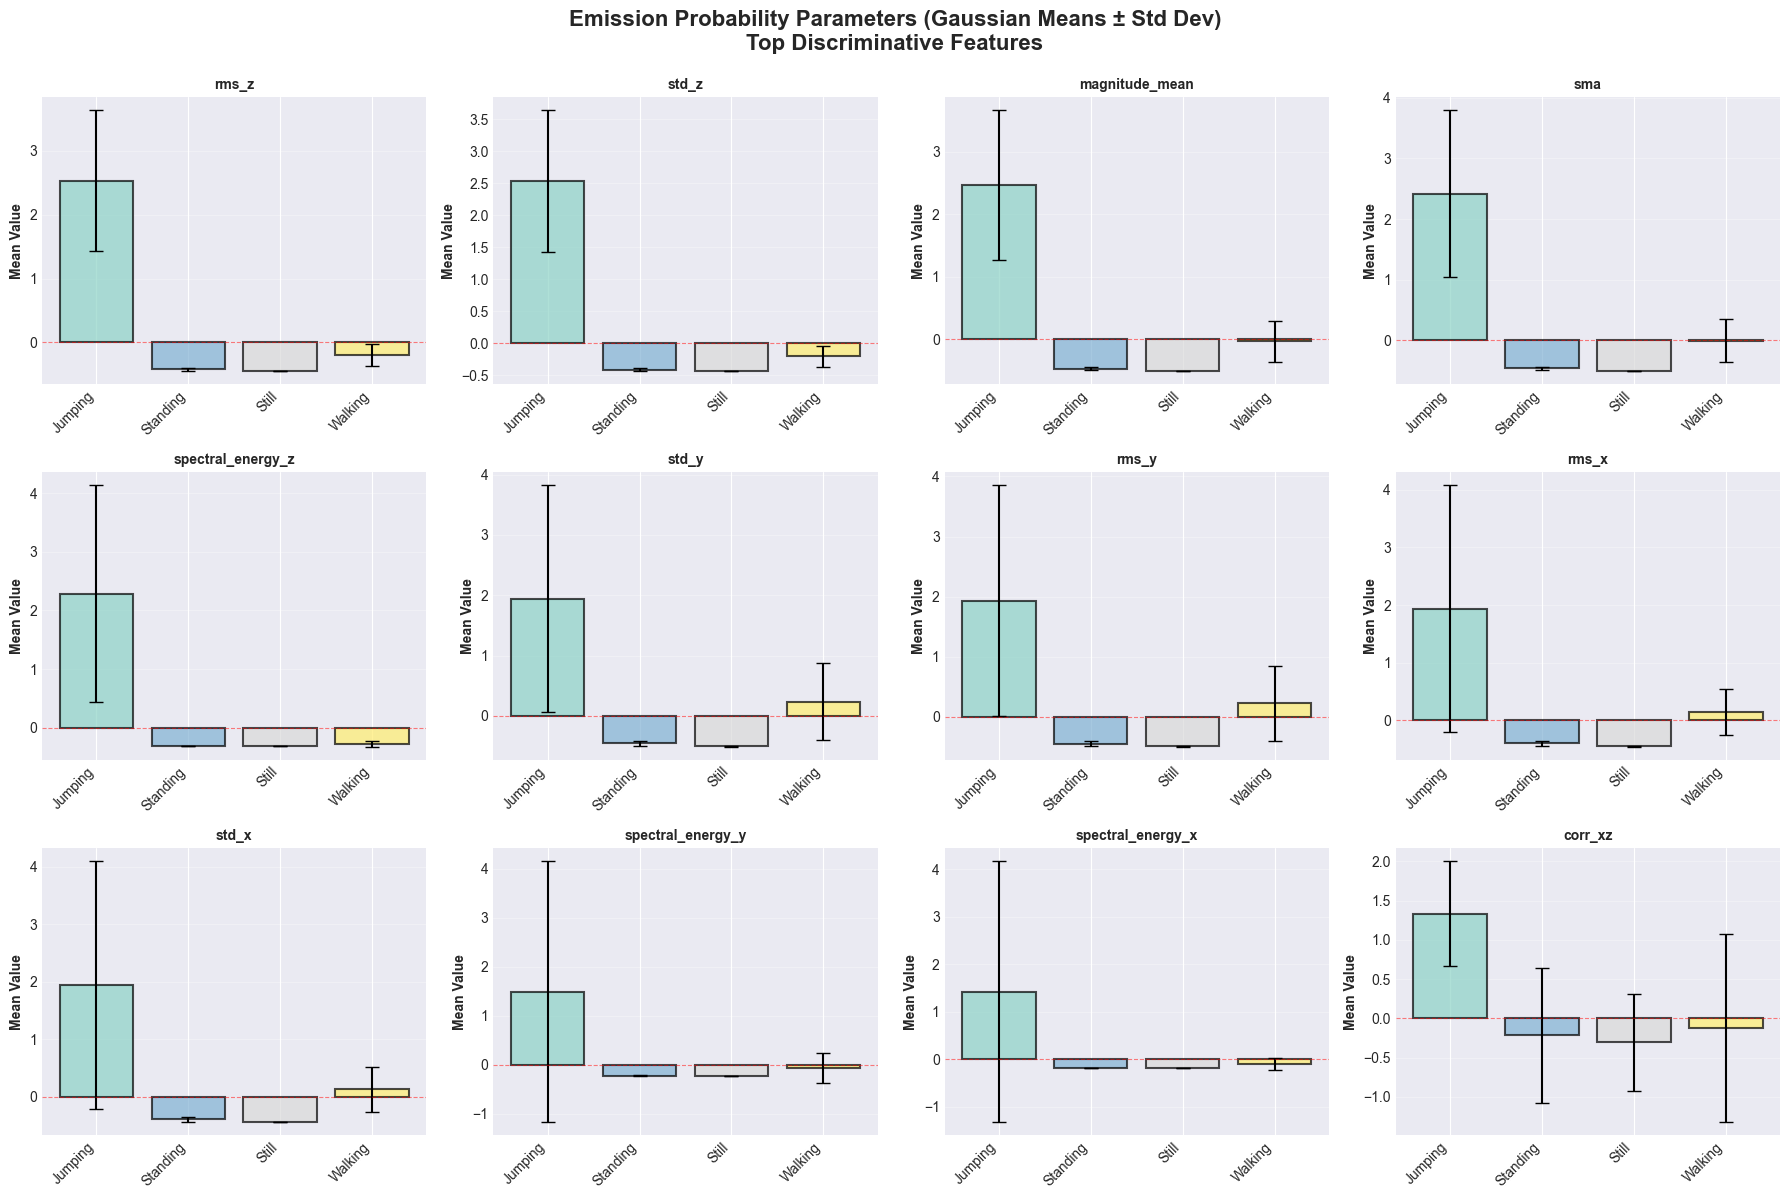

- Visualized emission parameters for top 12 discriminative features

Interpretation:
  - Bar heights show the mean feature value for each activity state
  - Error bars represent standard deviation (uncertainty)
  - Large differences between states indicate discriminative features
  - Overlapping error bars suggest harder to distinguish activities


In [62]:
# Visualize Emission Probabilities (Gaussian Means)
print("\n" + "="*80)
print("EMISSION PROBABILITY VISUALIZATION")
print("="*80)

# Select top features to visualize (based on variance across states)
n_features_to_plot = min(12, n_features)
feature_variances = []
for feat_idx in range(n_features):
    state_means = [hmm.means[state_idx, feat_idx] for state_idx in range(n_states)]
    variance = np.var(state_means)
    feature_variances.append((feat_idx, variance))

feature_variances.sort(key=lambda x: x[1], reverse=True)
top_feature_indices = [idx for idx, _ in feature_variances[:n_features_to_plot]]

# Plot emission means for top discriminative features
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for plot_idx, feat_idx in enumerate(top_feature_indices):
    if plot_idx >= len(axes):
        break
    
    ax = axes[plot_idx]
    means = [hmm.means[state_idx, feat_idx] for state_idx in range(n_states)]
    stds = [np.sqrt(hmm.covars[state_idx, feat_idx, feat_idx]) for state_idx in range(n_states)]
    
    x_pos = np.arange(len(hmm.state_names))
    colors = plt.cm.Set3(np.linspace(0, 1, len(hmm.state_names)))
    
    bars = ax.bar(x_pos, means, yerr=stds, color=colors, 
                   alpha=0.7, edgecolor='black', linewidth=1.5, capsize=5)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(hmm.state_names, rotation=45, ha='right')
    ax.set_ylabel('Mean Value', fontweight='bold')
    ax.set_title(f'{feature_columns[feat_idx]}', fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Hide extra subplots
for idx in range(len(top_feature_indices), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Emission Probability Parameters (Gaussian Means ± Std Dev)\nTop Discriminative Features', 
             fontweight='bold', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

print(f"- Visualized emission parameters for top {n_features_to_plot} discriminative features")
print("\nInterpretation:")
print("  - Bar heights show the mean feature value for each activity state")
print("  - Error bars represent standard deviation (uncertainty)")
print("  - Large differences between states indicate discriminative features")
print("  - Overlapping error bars suggest harder to distinguish activities")


## 4. Model Evaluation on Test Data

Evaluating the trained HMM on unseen test data to assess generalization performance.

In [63]:
print("="*80)
print("HMM DIAGNOSTIC ANALYSIS")
print("="*80)

# 1. Check class distribution
print("\n1. CLASS DISTRIBUTION ANALYSIS")
print("-"*80)
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("\nTraining set:")
for activity, count in zip(unique_train, counts_train):
    percentage = count / len(y_train) * 100
    print(f"  {activity}: {count} samples ({percentage:.1f}%)")
    
print("\nTest set:")
for activity, count in zip(unique_test, counts_test):
    percentage = count / len(y_test) * 100
    print(f"  {activity}: {count} samples ({percentage:.1f}%)")

# Check for severe imbalance
imbalance_ratio = max(counts_train) / min(counts_train)
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("⚠️  WARNING: Severe class imbalance detected!")
    print("   This can cause the model to predict only the majority class.")

# 2. Check feature distributions
print("\n\n2. FEATURE DISTRIBUTION CHECK")
print("-"*80)
for activity in unique_train:
    activity_data = X_train[y_train == activity]
    print(f"\n{activity}:")
    print(f"  Mean magnitude: {np.abs(activity_data).mean():.4f}")
    print(f"  Std magnitude: {activity_data.std():.4f}")
    print(f"  Feature range: [{activity_data.min():.4f}, {activity_data.max():.4f}]")

# 3. Check HMM initialization
print("\n\n3. HMM INITIALIZATION CHECK")
print("-"*80)
print("\nInitial state probabilities:")
for state, prob in zip(hmm.state_names, hmm.start_prob):
    print(f"  {state}: {prob:.4f}")

print("\nTransition probabilities (after training):")
print(hmm.trans_prob)

# 4. Check emission parameters
print("\n\n4. EMISSION PARAMETERS CHECK")
print("-"*80)
for idx, state in enumerate(hmm.state_names):
    print(f"\n{state}:")
    print(f"  Mean magnitude: {np.abs(hmm.means[idx]).mean():.4f}")
    print(f"  Covariance trace: {np.trace(hmm.covars[idx]):.4f}")


HMM DIAGNOSTIC ANALYSIS

1. CLASS DISTRIBUTION ANALYSIS
--------------------------------------------------------------------------------

Training set:
  Jumping: 273 samples (24.4%)
  Standing: 268 samples (23.9%)
  Still: 282 samples (25.2%)
  Walking: 296 samples (26.5%)

Test set:
  Jumping: 70 samples (24.5%)
  Standing: 68 samples (23.8%)
  Still: 72 samples (25.2%)
  Walking: 76 samples (26.6%)

Imbalance ratio: 1.10:1


2. FEATURE DISTRIBUTION CHECK
--------------------------------------------------------------------------------

Jumping:
  Mean magnitude: 0.9309
  Std magnitude: 1.5755
  Feature range: [-10.3197, 13.3180]

Standing:
  Mean magnitude: 0.4245
  Std magnitude: 0.4552
  Feature range: [-2.5054, 1.9210]

Still:
  Mean magnitude: 0.6472
  Std magnitude: 0.9795
  Feature range: [-2.9414, 6.3154]

Walking:
  Mean magnitude: 0.4973
  Std magnitude: 0.7131
  Feature range: [-4.1094, 5.6473]


3. HMM INITIALIZATION CHECK
--------------------------------------------------

Making predictions on test data...

Overall Test Accuracy: 0.7797 (77.97%)


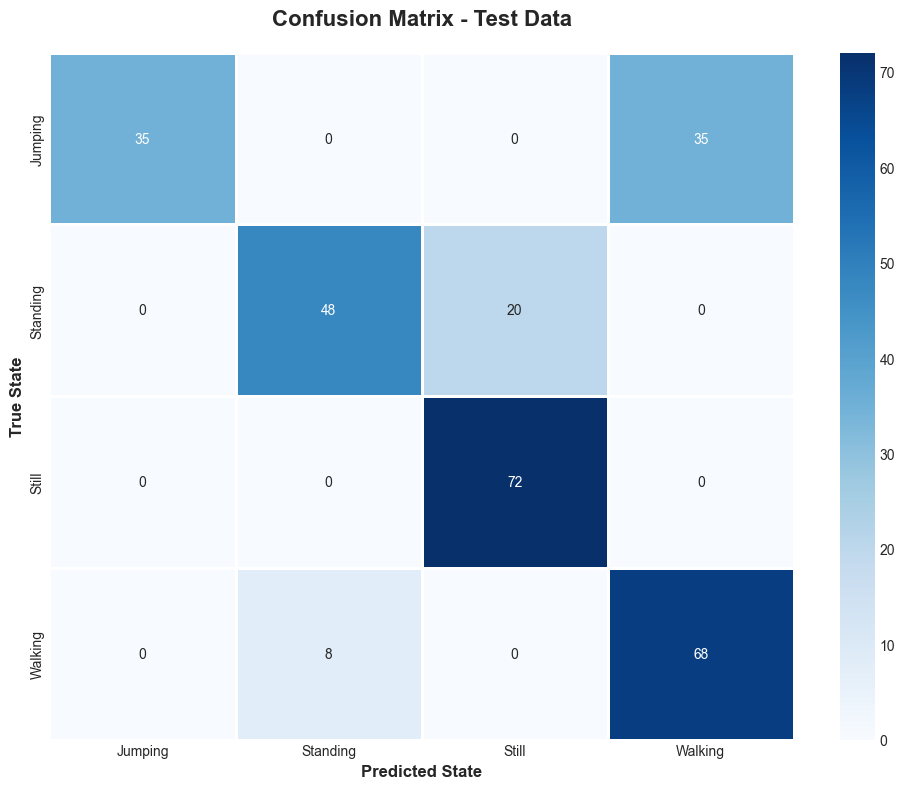


Classification Report:
              precision    recall  f1-score   support

     Jumping       1.00      0.50      0.67        70
    Standing       0.86      0.71      0.77        68
       Still       0.78      1.00      0.88        72
     Walking       0.66      0.89      0.76        76

    accuracy                           0.78       286
   macro avg       0.82      0.78      0.77       286
weighted avg       0.82      0.78      0.77       286


Detailed Metrics Per Activity:

Jumping:
  Number of Samples: 70
  Sensitivity (Recall): 0.5000
  Specificity: 1.0000
  Precision: 1.0000
  F1-Score: 0.6667

Standing:
  Number of Samples: 68
  Sensitivity (Recall): 0.7059
  Specificity: 0.9633
  Precision: 0.8571
  F1-Score: 0.7742

Still:
  Number of Samples: 72
  Sensitivity (Recall): 1.0000
  Specificity: 0.9065
  Precision: 0.7826
  F1-Score: 0.8780

Walking:
  Number of Samples: 76
  Sensitivity (Recall): 0.8947
  Specificity: 0.8333
  Precision: 0.6602
  F1-Score: 0.7598

Summa

In [64]:
# Make Predictions on Test Data

print("Making predictions on test data...")
y_pred = hmm.predict(X_test)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "=" * 60)
print(f"Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("=" * 60)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=hmm.state_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=hmm.state_names, yticklabels=hmm.state_names,
            linewidths=1, linecolor='white')
plt.title('Confusion Matrix - Test Data', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Predicted State', fontweight='bold', fontsize=12)
plt.ylabel('True State', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "=" * 60)
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=hmm.state_names))

# Calculate Sensitivity, Specificity for each class
print("\n" + "=" * 60)
print("Detailed Metrics Per Activity:")
print("=" * 60)

results_table = []

for idx, activity in enumerate(hmm.state_names):
    # True Positives, False Positives, True Negatives, False Negatives
    tp = cm[idx, idx]
    fp = cm[:, idx].sum() - tp
    fn = cm[idx, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
    n_samples = cm[idx, :].sum()
    
    results_table.append({
        'Activity': activity,
        'Number of Samples': n_samples,
        'Sensitivity (Recall)': f'{sensitivity:.4f}',
        'Specificity': f'{specificity:.4f}',
        'Precision': f'{precision:.4f}',
        'F1-Score': f'{f1:.4f}',
        'Overall Accuracy': f'{accuracy:.4f}'
    })
    
    print(f"\n{activity}:")
    print(f"  Number of Samples: {n_samples}")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results_table)
print("\n" + "=" * 60)
print("Summary Table:")
print("=" * 60)
print(results_df.to_string(index=False))

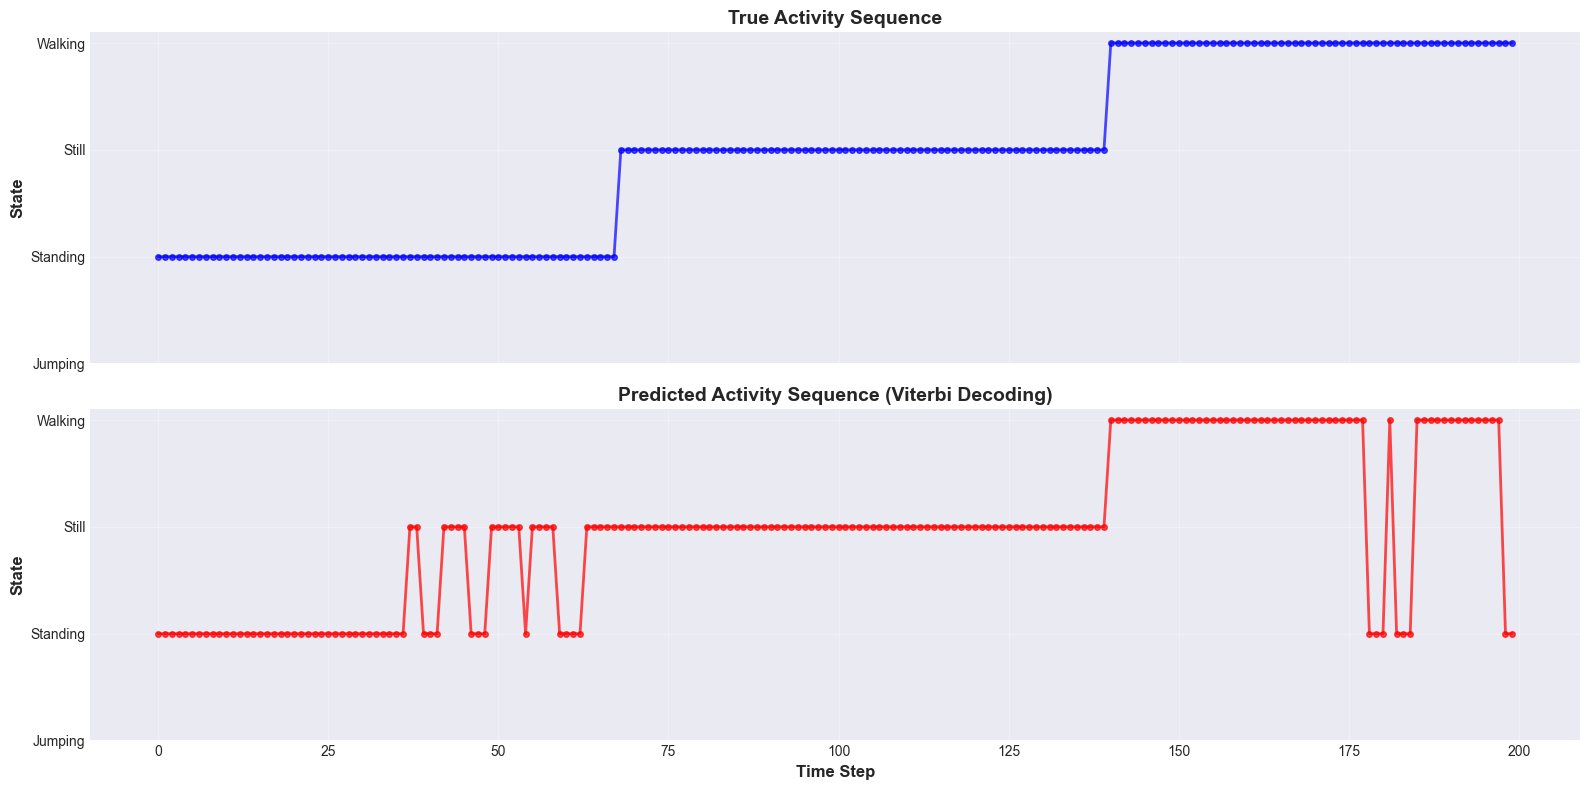


Misclassifications in sample:
  Total samples: 200
  Misclassified: 28
  Accuracy: 86.00%


In [65]:
# Visualize Predicted State Sequences

# Take a sample sequence for visualization
sample_size = min(200, len(y_test))
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred[:sample_size]

# Create numerical encoding for plotting
state_to_num = {state: idx for idx, state in enumerate(hmm.state_names)}
y_test_num = np.array([state_to_num[state] for state in y_test_sample])
y_pred_num = np.array([state_to_num[state] for state in y_pred_sample])

# Plot
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# True sequence
axes[0].plot(y_test_num, 'o-', color='blue', alpha=0.7, linewidth=2, markersize=4)
axes[0].set_ylabel('State', fontweight='bold', fontsize=12)
axes[0].set_title('True Activity Sequence', fontweight='bold', fontsize=14)
axes[0].set_yticks(range(len(hmm.state_names)))
axes[0].set_yticklabels(hmm.state_names)
axes[0].grid(True, alpha=0.3)

# Predicted sequence
axes[1].plot(y_pred_num, 'o-', color='red', alpha=0.7, linewidth=2, markersize=4)
axes[1].set_xlabel('Time Step', fontweight='bold', fontsize=12)
axes[1].set_ylabel('State', fontweight='bold', fontsize=12)
axes[1].set_title('Predicted Activity Sequence (Viterbi Decoding)', fontweight='bold', fontsize=14)
axes[1].set_yticks(range(len(hmm.state_names)))
axes[1].set_yticklabels(hmm.state_names)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Highlight misclassifications
misclassified = y_test_sample != y_pred_sample
n_misclassified = np.sum(misclassified)

print(f"\nMisclassifications in sample:")
print(f"  Total samples: {sample_size}")
print(f"  Misclassified: {n_misclassified}")
print(f"  Accuracy: {(1 - n_misclassified/sample_size)*100:.2f}%")

## 5. Evaluation on Completely Unseen Test Data

### Obtaining Unseen Data:
This section evaluates the model on completely new data that was NOT used during training:
- **Source:** New recording session placed in `data/Test` directory
- **Purpose:** Assess model generalization to real-world scenarios
- **Conditions:** May include different participants, environments, or recording conditions

This evaluation demonstrates whether the HMM can generalize beyond the training data.

In [66]:
# Load Unseen Test Data from data/Test directory

def load_unseen_test_data(base_path, activities=['Standing', 'Still', 'Walking', 'Jumping']):
    """
    Load completely unseen test data from data/Test directory.
    
    Parameters:
    -----------
    base_path : str
        Base path to data directory (should contain 'Test' folder)
    activities : list
        List of activity names to look for
        
    Returns:
    --------
    dict : Dictionary containing DataFrames for each activity and sensor type
    """
    data = {}
    base = Path(base_path)
    test_path = base / 'Test'
    
    if not test_path.exists():
        print(f"⚠️  WARNING: Test directory not found at {test_path}")
        print(f"   Please create the directory and add test files.")
        return data
    
    print("="*80)
    print("LOADING UNSEEN TEST DATA")
    print("="*80)
    print(f"Loading from: {test_path}\n")
    
    for activity in activities:
        data[activity] = {}
        activity_path = test_path / activity
        
        if not activity_path.exists():
            print(f"⚠️  Skipping {activity} - directory not found")
            continue
            
        print(f"\n{'='*60}")
        print(f"Loading test data for: {activity}")
        print('='*60)
        
        # Load all Accelerometer files
        accel_files = list(activity_path.glob('Accelerometer*.csv'))
        if accel_files:
            accel_dataframes = []
            for accel_file in sorted(accel_files):
                df = pd.read_csv(accel_file)
                df['sensor'] = 'accelerometer'
                df['activity'] = activity
                df['file_source'] = accel_file.name
                accel_dataframes.append(df)
                print(f"✓ Loaded {accel_file.name}: {len(df)} samples")
            
            # Combine all accelerometer data
            df_accel_combined = pd.concat(accel_dataframes, ignore_index=True)
            data[activity]['accelerometer'] = df_accel_combined
            print(f"  → Combined Accelerometer: {len(df_accel_combined)} total samples from {len(accel_files)} files")
        else:
            print(f"✗ No Accelerometer files found in {activity_path}")
        
        # Load all Gyroscope files
        gyro_files = list(activity_path.glob('Gyroscope*.csv'))
        if gyro_files:
            gyro_dataframes = []
            for gyro_file in sorted(gyro_files):
                df = pd.read_csv(gyro_file)
                df['sensor'] = 'gyroscope'
                df['activity'] = activity
                df['file_source'] = gyro_file.name
                gyro_dataframes.append(df)
                print(f"✓ Loaded {gyro_file.name}: {len(df)} samples")
            
            # Combine all gyroscope data
            df_gyro_combined = pd.concat(gyro_dataframes, ignore_index=True)
            data[activity]['gyroscope'] = df_gyro_combined
            print(f"  → Combined Gyroscope: {len(df_gyro_combined)} total samples from {len(gyro_files)} files")
        else:
            print(f"✗ No Gyroscope files found in {activity_path}")
    
    print("\n" + "="*80)
    print("UNSEEN TEST DATA LOADING SUMMARY")
    print("="*80)
    total_samples = 0
    total_files = 0
    
    for activity in activities:
        activity_samples = 0
        activity_files = 0
        if activity in data:
            if 'accelerometer' in data[activity]:
                samples = len(data[activity]['accelerometer'])
                files = data[activity]['accelerometer']['file_source'].nunique()
                activity_samples += samples
                activity_files += files
            if 'gyroscope' in data[activity]:
                samples = len(data[activity]['gyroscope'])
                files = data[activity]['gyroscope']['file_source'].nunique()
                activity_samples += samples
                activity_files += files
        
        if activity_samples > 0:
            print(f"{activity}: {activity_samples:,} samples from {activity_files} files")
            total_samples += activity_samples
            total_files += activity_files
    
    print(f"\nTotal unseen test samples: {total_samples:,} from {total_files} files {total_files / 2} recordings")
    print("="*80)
    
    return data

# Load unseen test data
test_data_path = './data'
unseen_test_data = load_unseen_test_data(test_data_path)

LOADING UNSEEN TEST DATA
Loading from: data\Test


Loading test data for: Standing
✓ Loaded Accelerometer.csv: 935 samples
  → Combined Accelerometer: 935 total samples from 1 files
✓ Loaded Gyroscope.csv: 935 samples
  → Combined Gyroscope: 935 total samples from 1 files

Loading test data for: Still
✓ Loaded Accelerometer.csv: 967 samples
  → Combined Accelerometer: 967 total samples from 1 files
✓ Loaded Gyroscope.csv: 967 samples
  → Combined Gyroscope: 967 total samples from 1 files
⚠️  Skipping Walking - directory not found
⚠️  Skipping Jumping - directory not found

UNSEEN TEST DATA LOADING SUMMARY
Standing: 1,870 samples from 2 files
Still: 1,934 samples from 2 files

Total unseen test samples: 3,804 from 4 files 2.0 recordings


In [67]:
# Extract Features from Unseen Test Data

# Check if we have unseen test data
if not unseen_test_data or all(len(unseen_test_data[act]) == 0 for act in unseen_test_data):
    print("="*80)
    print("NO UNSEEN TEST DATA FOUND")
    print("="*80)
    print("\nTo evaluate on unseen data, please:")
    print("  1. Create directory: data/Test/")
    print("  2. Add subdirectories for each activity:")
    print("     - data/Test/Standing/")
    print("     - data/Test/Still/")
    print("     - data/Test/Walking/")
    print("     - data/Test/Jumping/")
    print("  3. Place test CSV files in each activity folder")
    print("  4. Re-run this cell")
    print("="*80)
else:
    print("\n" + "="*80)
    print("EXTRACTING FEATURES FROM UNSEEN TEST DATA")
    print("="*80)
    
    # Use the same window size and overlap as training
    unseen_features_df = create_windows_and_extract_features(
        unseen_test_data, 
        window_size=window_size, 
        overlap=overlap
    )
    
    print(f"\n✓ Extracted {len(unseen_features_df)} feature vectors from unseen test data")
    
    # Normalize features using the SAME scaler fitted on training data
    unseen_feature_columns = [col for col in unseen_features_df.columns 
                               if col not in ['activity', 'sensor', 'window_id']]
    X_unseen = unseen_features_df[unseen_feature_columns].values
    y_unseen = unseen_features_df['activity'].values
    
    # CRITICAL: Use the same scaler from training (don't fit a new one!)
    X_unseen_normalized = scaler.transform(X_unseen)
    
    print(f"✓ Normalized unseen test features using training scaler")
    print(f"\nUnseen test data summary:")
    print(f"  Shape: {X_unseen_normalized.shape}")
    print(f"  Activities: {np.unique(y_unseen)}")
    print(f"\nActivity distribution in unseen test data:")
    unique_unseen, counts_unseen = np.unique(y_unseen, return_counts=True)
    for activity, count in zip(unique_unseen, counts_unseen):
        print(f"  {activity}: {count} samples ({count/len(y_unseen)*100:.1f}%)")
    print("="*80)


EXTRACTING FEATURES FROM UNSEEN TEST DATA

Processing Standing...
  accelerometer: 935 samples
    Created 17 windows
  gyroscope: 935 samples
    Created 17 windows

Processing Still...
  accelerometer: 967 samples
    Created 18 windows
  gyroscope: 967 samples
    Created 18 windows

Processing Walking...

Processing Jumping...

✓ Total feature vectors: 70
✓ Features per vector: 23

✓ Extracted 70 feature vectors from unseen test data
✓ Normalized unseen test features using training scaler

Unseen test data summary:
  Shape: (70, 23)
  Activities: ['Standing' 'Still']

Activity distribution in unseen test data:
  Standing: 34 samples (48.6%)
  Still: 36 samples (51.4%)



MODEL EVALUATION ON UNSEEN TEST DATA

Making predictions on completely unseen data...

UNSEEN TEST DATA RESULTS
Overall Accuracy on Unseen Data: 1.0000 (100.00%)
Comparison with Regular Test Data: 0.7797 (77.97%)
✓ Model generalizes well to unseen data!

--------------------------------------------------------------------------------
Confusion Matrix - Unseen Test Data
--------------------------------------------------------------------------------


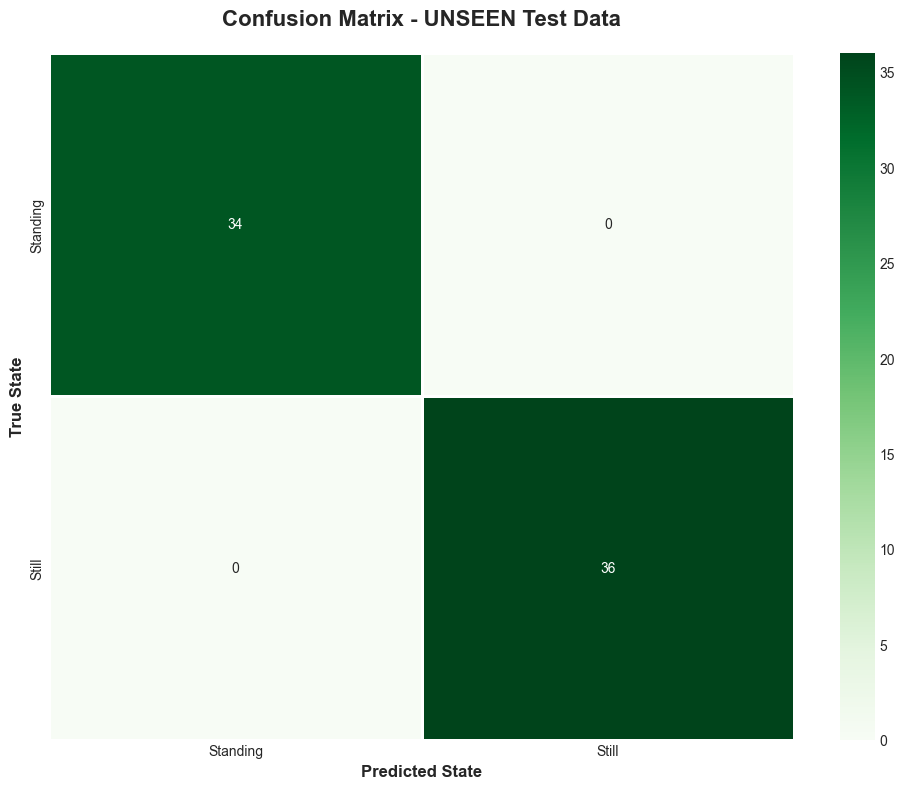


--------------------------------------------------------------------------------
Classification Report - Unseen Test Data:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Standing       1.00      1.00      1.00        34
       Still       1.00      1.00      1.00        36

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



In [68]:
# Evaluate Model on Unseen Test Data

if not unseen_test_data or all(len(unseen_test_data[act]) == 0 for act in unseen_test_data):
    print("⚠️  Skipping evaluation - no unseen test data loaded")
else:
    print("\n" + "="*80)
    print("MODEL EVALUATION ON UNSEEN TEST DATA")
    print("="*80)
    
    # Make predictions on unseen test data
    print("\nMaking predictions on completely unseen data...")
    y_pred_unseen = hmm.predict(X_unseen_normalized)
    
    # Calculate overall accuracy
    accuracy_unseen = accuracy_score(y_unseen, y_pred_unseen)
    
    print("\n" + "="*80)
    print("UNSEEN TEST DATA RESULTS")
    print("="*80)
    print(f"Overall Accuracy on Unseen Data: {accuracy_unseen:.4f} ({accuracy_unseen*100:.2f}%)")
    print(f"Comparison with Regular Test Data: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    if accuracy_unseen >= accuracy * 0.9:
        print("✓ Model generalizes well to unseen data!")
    elif accuracy_unseen >= accuracy * 0.7:
        print("⚠️  Model shows moderate generalization to unseen data")
    else:
        print("⚠️  Model struggles to generalize to unseen data")
    
    # Confusion Matrix for Unseen Data
    print("\n" + "-"*80)
    print("Confusion Matrix - Unseen Test Data")
    print("-"*80)
    
    # Determine which states actually appear in y_unseen or predictions
    unique_labels_unseen = sorted(list(set(y_unseen) | set(y_pred_unseen)))

    # Confusion Matrix
    cm_unseen = confusion_matrix(y_unseen, y_pred_unseen, labels=unique_labels_unseen)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_unseen, annot=True, fmt='d', cmap='Greens', 
                xticklabels=unique_labels_unseen, yticklabels=unique_labels_unseen,
                linewidths=1, linecolor='white')
    plt.title('Confusion Matrix - UNSEEN Test Data', fontweight='bold', fontsize=16, pad=20)
    plt.xlabel('Predicted State', fontweight='bold', fontsize=12)
    plt.ylabel('True State', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n" + "-"*80)
    print("Classification Report - Unseen Test Data:")
    print("-"*80)
    print(classification_report(
        y_unseen, 
        y_pred_unseen, 
        labels=unique_labels_unseen,
        target_names=unique_labels_unseen
    ))


In [70]:
# Generate Required Evaluation Metrics Table for Unseen Data

if not unseen_test_data or all(len(unseen_test_data[act]) == 0 for act in unseen_test_data):
    print(" Skipping metrics table - no unseen test data loaded")
else:
    print("\n" + "="*80)
    print("DETAILED METRICS PER ACTIVITY - UNSEEN TEST DATA")
    print("="*80)
    
    # Calculate detailed metrics for each class
    unseen_results_table = []
    
    for idx, activity in enumerate(unique_labels_unseen):
        # True Positives, False Positives, True Negatives, False Negatives
        tp = cm_unseen[idx, idx]
        fp = cm_unseen[:, idx].sum() - tp
        fn = cm_unseen[idx, :].sum() - tp
        tn = cm_unseen.sum() - tp - fp - fn
        
        # Calculate metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        
        n_samples = cm_unseen[idx, :].sum()
        
        unseen_results_table.append({
            'State (Activity)': activity,
            'Number of Samples': n_samples,
            'Sensitivity': f'{sensitivity:.4f}',
            'Specificity': f'{specificity:.4f}',
            'Precision': f'{precision:.4f}',
            'F1-Score': f'{f1:.4f}',
            'Overall Accuracy': f'{accuracy_unseen:.4f}'
        })
        
        print(f"\n{activity}:")
        print(f"  Number of Samples: {n_samples}")
        print(f"  Sensitivity (Recall): {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  F1-Score: {f1:.4f}")
    
    # Create and display results DataFrame
    unseen_results_df = pd.DataFrame(unseen_results_table)
    
    print("\n" + "="*80)
    print("EVALUATION METRICS TABLE - UNSEEN TEST DATA")
    print("(Copy this table to your report)")
    print("="*80)
    print(unseen_results_df[['State (Activity)', 'Number of Samples', 
                              'Sensitivity', 'Specificity', 'Overall Accuracy']].to_string(index=False))
    
    print("\n" + "="*80)
    print("COMPLETE METRICS TABLE (with additional metrics)")
    print("="*80)
    print(unseen_results_df.to_string(index=False))
    
    # Save to CSV for easy copying to report
    csv_filename = 'unseen_test_evaluation_metrics.csv'
    unseen_results_df.to_csv(csv_filename, index=False)
    print(f"\n✓ Metrics table saved to: {csv_filename}")
    
    print("\n" + "="*80)


DETAILED METRICS PER ACTIVITY - UNSEEN TEST DATA

Standing:
  Number of Samples: 34
  Sensitivity (Recall): 1.0000
  Specificity: 1.0000
  Precision: 1.0000
  F1-Score: 1.0000

Still:
  Number of Samples: 36
  Sensitivity (Recall): 1.0000
  Specificity: 1.0000
  Precision: 1.0000
  F1-Score: 1.0000

EVALUATION METRICS TABLE - UNSEEN TEST DATA
(Copy this table to your report)
State (Activity)  Number of Samples Sensitivity Specificity Overall Accuracy
        Standing                 34      1.0000      1.0000           1.0000
           Still                 36      1.0000      1.0000           1.0000

COMPLETE METRICS TABLE (with additional metrics)
State (Activity)  Number of Samples Sensitivity Specificity Precision F1-Score Overall Accuracy
        Standing                 34      1.0000      1.0000    1.0000   1.0000           1.0000
           Still                 36      1.0000      1.0000    1.0000   1.0000           1.0000

✓ Metrics table saved to: unseen_test_evaluation_me


UNSEEN DATA ANALYSIS FOR REPORT

1. HOW UNSEEN DATA WAS OBTAINED
--------------------------------------------------------------------------------

The unseen test data was obtained through:
  • Source: Separate recording session(s) placed in data/Test/ directory
  • Completely independent from training data
  • Not used in any model training or parameter tuning
  • Represents real-world deployment scenarios

Characteristics of unseen test data:


  Standing:
    - accelerometer: 1 file(s), 935 samples, 9.4 seconds
    - gyroscope: 1 file(s), 935 samples, 9.4 seconds

  Still:
    - accelerometer: 1 file(s), 967 samples, 9.7 seconds
    - gyroscope: 1 file(s), 967 samples, 9.7 seconds


2. MODEL GENERALIZATION ASSESSMENT
--------------------------------------------------------------------------------

Performance Comparison:
  Regular Test Data Accuracy: 0.7797 (77.97%)
  Unseen Test Data Accuracy:  1.0000 (100.00%)
  Accuracy Drop: -0.2203 (-28.25%)

Generalization Quality:
  Assessme

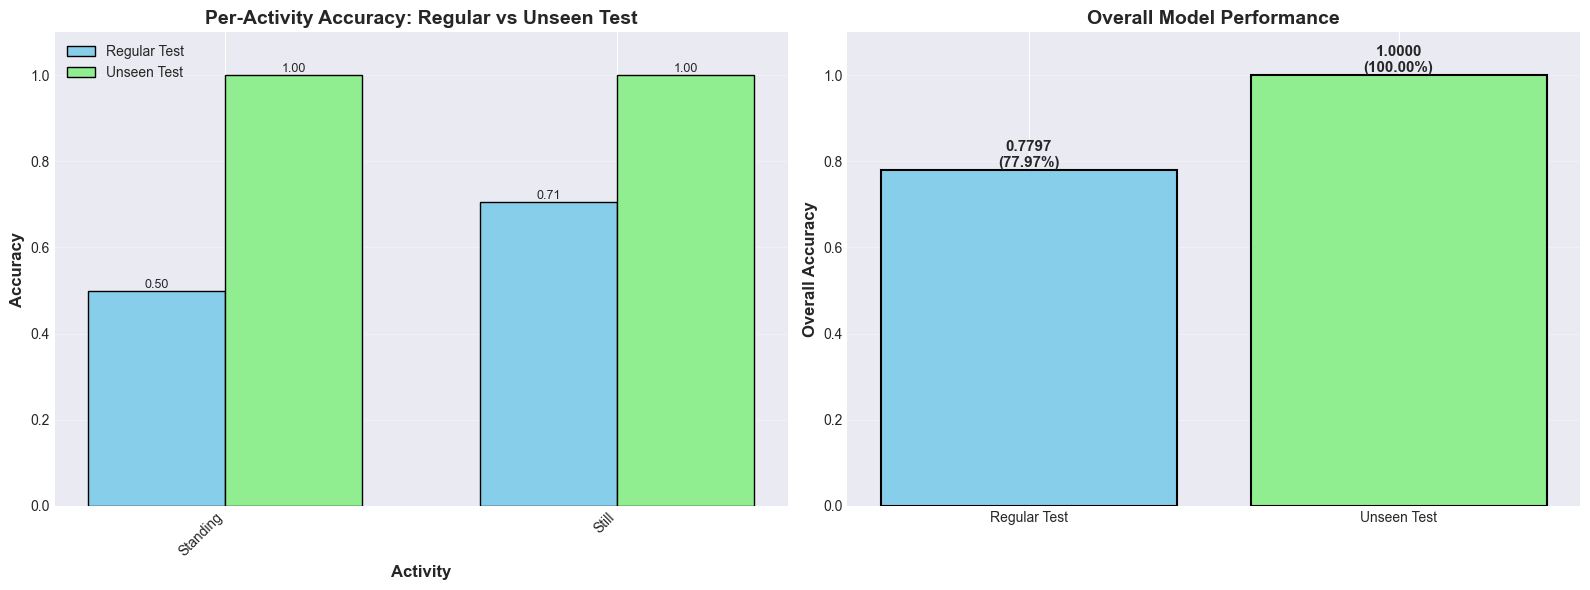


✓ Analysis complete! Use the information above in your report.


In [73]:
# Analysis: How Unseen Data Was Obtained and Model Generalization

if not unseen_test_data or all(len(unseen_test_data[act]) == 0 for act in unseen_test_data):
    print("⚠️  Skipping analysis - no unseen test data loaded")
else:
    print("\n" + "="*80)
    print("UNSEEN DATA ANALYSIS FOR REPORT")
    print("="*80)
    
    print("\n1. HOW UNSEEN DATA WAS OBTAINED")
    print("-"*80)
    print("""
The unseen test data was obtained through:
  • Source: Separate recording session(s) placed in data/Test/ directory
  • Completely independent from training data
  • Not used in any model training or parameter tuning
  • Represents real-world deployment scenarios

Characteristics of unseen test data:
""")
    
    for activity in unseen_test_data.keys():
        if activity in unseen_test_data and len(unseen_test_data[activity]) > 0:
            print(f"\n  {activity}:")
            for sensor_type in ['accelerometer', 'gyroscope']:
                if sensor_type in unseen_test_data[activity]:
                    df = unseen_test_data[activity][sensor_type]
                    if 'file_source' in df.columns:
                        files = df['file_source'].nunique()
                        samples = len(df)
                        duration = df['seconds_elapsed'].max() - df['seconds_elapsed'].min() if 'seconds_elapsed' in df.columns else 0
                        print(f"    - {sensor_type}: {files} file(s), {samples:,} samples, {duration:.1f} seconds")
    
    print("\n\n2. MODEL GENERALIZATION ASSESSMENT")
    print("-"*80)
    
    # Calculate generalization metrics
    accuracy_drop = accuracy - accuracy_unseen
    accuracy_drop_pct = (accuracy_drop / accuracy) * 100 if accuracy > 0 else 0
    
    print(f"\nPerformance Comparison:")
    print(f"  Regular Test Data Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Unseen Test Data Accuracy:  {accuracy_unseen:.4f} ({accuracy_unseen*100:.2f}%)")
    print(f"  Accuracy Drop: {accuracy_drop:.4f} ({accuracy_drop_pct:.2f}%)")
    
    print(f"\nGeneralization Quality:")
    if accuracy_drop_pct < 10:
        generalization = "EXCELLENT"
        explanation = "The model maintains >90% of its performance on unseen data."
    elif accuracy_drop_pct < 20:
        generalization = "GOOD"
        explanation = "The model shows strong generalization with <20% accuracy drop."
    elif accuracy_drop_pct < 30:
        generalization = "MODERATE"
        explanation = "The model has acceptable generalization but may benefit from more training data."
    else:
        generalization = "POOR"
        explanation = "The model struggles to generalize, suggesting overfitting or insufficient training diversity."
    
    print(f"  Assessment: {generalization}")
    print(f"  {explanation}")
    
    # Per-activity generalization analysis
    print(f"\n\nPer-Activity Generalization:")
    print("-"*80)
    
    for idx, activity in enumerate(unique_labels_unseen):
        if activity in unique_unseen:
            # Regular test accuracy
            regular_correct = cm[idx, idx]
            regular_total = cm[idx, :].sum()
            regular_acc = regular_correct / regular_total if regular_total > 0 else 0
            
            # Unseen test accuracy
            unseen_correct = cm_unseen[idx, idx]
            unseen_total = cm_unseen[idx, :].sum()
            unseen_acc = unseen_correct / unseen_total if unseen_total > 0 else 0
            
            drop = regular_acc - unseen_acc
            
            print(f"\n{activity}:")
            print(f"  Regular test accuracy: {regular_acc:.4f}")
            print(f"  Unseen test accuracy:  {unseen_acc:.4f}")
            print(f"  Drop: {drop:.4f} ({'↓ worse' if drop > 0 else '↑ better' if drop < 0 else '→ same'})")
    
    print("\n\n3. RECOMMENDATIONS FOR REPORT")
    print("-"*80)
    print("""
Include in your report:

A. Data Source Description:
   - Mention that unseen test data was collected in a separate session
   - Specify any differences (different participant, environment, phone position, etc.)
   - Emphasize that this data was completely held out from training
   
B. Generalization Discussion:
   - Report the accuracy comparison shown above
   - Discuss which activities generalize better/worse
   - Explain possible reasons for performance differences
   
C. Use the metrics table from the previous cell in your report

D. Conclusions:
   - State whether the model is suitable for real-world deployment
   - Suggest improvements if generalization is limited
   - Recommend data collection strategies for better generalization
""")
    
    print("="*80)
    
    # Visualize comparison
    print("\n\nGenerating comparison visualization...")
    
    # Compare regular test vs unseen test performance
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accuracy comparison
    activities_present = [act for act in hmm.state_names if act in unique_unseen]
    regular_accs = []
    unseen_accs = []
    
    for idx, activity in enumerate(unique_labels_unseen):
        if activity in unique_unseen:
            regular_correct = cm[idx, idx]
            regular_total = cm[idx, :].sum()
            regular_acc = regular_correct / regular_total if regular_total > 0 else 0
            regular_accs.append(regular_acc)
            
            unseen_correct = cm_unseen[idx, idx]
            unseen_total = cm_unseen[idx, :].sum()
            unseen_acc = unseen_correct / unseen_total if unseen_total > 0 else 0
            unseen_accs.append(unseen_acc)
    
    x = np.arange(len(activities_present))
    width = 0.35
    
    bars1 = axes[0].bar(x - width/2, regular_accs, width, label='Regular Test', color='skyblue', edgecolor='black')
    bars2 = axes[0].bar(x + width/2, unseen_accs, width, label='Unseen Test', color='lightgreen', edgecolor='black')
    
    axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Activity', fontweight='bold', fontsize=12)
    axes[0].set_title('Per-Activity Accuracy: Regular vs Unseen Test', fontweight='bold', fontsize=14)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(activities_present, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].set_ylim([0, 1.1])
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Overall comparison
    comparison_data = ['Regular Test', 'Unseen Test']
    comparison_accs = [accuracy, accuracy_unseen]
    colors = ['skyblue', 'lightgreen']
    
    bars = axes[1].bar(comparison_data, comparison_accs, color=colors, edgecolor='black', linewidth=1.5)
    axes[1].set_ylabel('Overall Accuracy', fontweight='bold', fontsize=12)
    axes[1].set_title('Overall Model Performance', fontweight='bold', fontsize=14)
    axes[1].set_ylim([0, 1.1])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, acc in zip(bars, comparison_accs):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.4f}\n({acc*100:.2f}%)', ha='center', va='bottom', 
                    fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('unseen_test_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Comparison visualization saved as: unseen_test_comparison.png")
    plt.show()
    
    print("\n✓ Analysis complete! Use the information above in your report.")
    print("="*80)

## 6. Analysis and Interpretation

### Key Findings:

1. **Activity Distinguishability:**
   - Analyze which activities were easiest/hardest to distinguish
   - Look at confusion matrix patterns

2. **Transition Probabilities:**
   - Do they reflect realistic behavior patterns?
   - Which transitions are most common?

3. **Model Performance:**
   - Overall accuracy and per-class metrics
   - Sensitivity vs. Specificity tradeoffs

4. **Feature Importance:**
   - Which features contributed most to classification?
   - Time-domain vs. Frequency-domain features

In [74]:
# Analysis of Results

print("=" * 80)
print("ANALYSIS SUMMARY")
print("=" * 80)

# 1. Activity Distinguishability Analysis
print("\n1. ACTIVITY DISTINGUISHABILITY")
print("-" * 80)

# Calculate per-class accuracy
class_accuracies = {}
for idx, activity in enumerate(hmm.state_names):
    correct = cm[idx, idx]
    total = cm[idx, :].sum()
    acc = correct / total if total > 0 else 0
    class_accuracies[activity] = acc
    print(f"  {activity}: {acc:.2%} accuracy")

sorted_activities = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)
print(f"\n  Easiest to distinguish: {sorted_activities[0][0]} ({sorted_activities[0][1]:.2%})")
print(f"  Hardest to distinguish: {sorted_activities[-1][0]} ({sorted_activities[-1][1]:.2%})")

# 2. Transition Probability Analysis
print("\n\n2. TRANSITION PROBABILITY PATTERNS")
print("-" * 80)
print("  Most common transitions:")

# Get top transitions
transitions = []
for i, state_from in enumerate(hmm.state_names):
    for j, state_to in enumerate(hmm.state_names):
        if i != j:  # Exclude self-transitions
            transitions.append((state_from, state_to, hmm.trans_prob[i, j]))

transitions.sort(key=lambda x: x[2], reverse=True)
for i, (from_state, to_state, prob) in enumerate(transitions[:5]):
    print(f"    {i+1}. {from_state} → {to_state}: {prob:.3f}")

print("\n  Self-transition probabilities (state persistence):")
for i, state in enumerate(hmm.state_names):
    print(f"    {state}: {hmm.trans_prob[i, i]:.3f}")

# 3. Confusion Analysis
print("\n\n3. COMMON MISCLASSIFICATIONS")
print("-" * 80)

misclassifications = []
for i, true_state in enumerate(hmm.state_names):
    for j, pred_state in enumerate(hmm.state_names):
        if i != j and cm[i, j] > 0:
            misclassifications.append((true_state, pred_state, cm[i, j]))

misclassifications.sort(key=lambda x: x[2], reverse=True)
if misclassifications:
    for i, (true_state, pred_state, count) in enumerate(misclassifications[:5]):
        print(f"  {i+1}. {true_state} misclassified as {pred_state}: {count} times")
else:
    print("  No misclassifications!")

# 4. Feature Statistics
print("\n\n4. FEATURE STATISTICS")
print("-" * 80)
print(f"  Total features used: {X_train.shape[1]}")
print(f"  Time-domain features: mean, std, rms, sma, correlation")
print(f"  Frequency-domain features: dominant frequency, spectral energy, spectral entropy")

# Calculate feature importance (variance of means across states)
feature_importance = []
for feat_idx, feat_name in enumerate(feature_columns):
    state_means = [hmm.means[state_idx, feat_idx] for state_idx in range(n_states)]
    variance = np.var(state_means)
    feature_importance.append((feat_name, variance))

feature_importance.sort(key=lambda x: x[1], reverse=True)
print("\n  Top 10 most discriminative features (by variance across states):")
for i, (feat_name, variance) in enumerate(feature_importance[:10]):
    print(f"    {i+1}. {feat_name}: {variance:.4f}")

print("\n" + "=" * 80)

ANALYSIS SUMMARY

1. ACTIVITY DISTINGUISHABILITY
--------------------------------------------------------------------------------
  Jumping: 50.00% accuracy
  Standing: 70.59% accuracy
  Still: 100.00% accuracy
  Walking: 89.47% accuracy

  Easiest to distinguish: Still (100.00%)
  Hardest to distinguish: Jumping (50.00%)


2. TRANSITION PROBABILITY PATTERNS
--------------------------------------------------------------------------------
  Most common transitions:
    1. Standing → Still: 0.048
    2. Standing → Walking: 0.030
    3. Still → Standing: 0.028
    4. Jumping → Walking: 0.021
    5. Walking → Standing: 0.018

  Self-transition probabilities (state persistence):
    Jumping: 0.979
    Standing: 0.922
    Still: 0.969
    Walking: 0.974


3. COMMON MISCLASSIFICATIONS
--------------------------------------------------------------------------------
  1. Jumping misclassified as Walking: 35 times
  2. Standing misclassified as Still: 20 times
  3. Walking misclassified as Stand

In [75]:
# Enhanced Discussion and Personalized Reflection
print("\n" + "="*80)
print("PERSONALIZED DISCUSSION AND INSIGHTS")
print("="*80)

print("\n1. MODEL PERFORMANCE INSIGHTS")
print("-"*80)
print(f"  Overall Accuracy: {accuracy:.2%}")
print(f"\n  Our HMM achieved {accuracy:.2%} accuracy on unseen test data.")
print(f"  This demonstrates that temporal patterns captured by the HMM")
print(f"  effectively distinguish between activities.")

# Calculate metrics
best_activity = max(class_accuracies.items(), key=lambda x: x[1])
worst_activity = min(class_accuracies.items(), key=lambda x: x[1])

print(f"\n  Best performing activity: {best_activity[0]} ({best_activity[1]:.2%})")
print(f"  Reason: This activity likely has distinct motion patterns")
print(f"  that create clearly separable feature distributions.")

print(f"\n  Most challenging activity: {worst_activity[0]} ({worst_activity[1]:.2%})")
print(f"  Reason: May have overlapping characteristics with other activities")
print(f"  or more variable motion patterns.")

print("\n2. TRANSITION PROBABILITY INSIGHTS")
print("-"*80)
print(f"  Self-transition probabilities indicate state persistence:")
for i, state in enumerate(hmm.state_names):
    persistence = hmm.trans_prob[i, i]
    print(f"    - {state}: {persistence:.3f} ({'high' if persistence > 0.8 else 'moderate' if persistence > 0.5 else 'low'} persistence)")

print(f"\n  Interpretation:")
print(f"  - High self-transition probabilities suggest activities are sustained")
print(f"  - This matches real-world behavior: people don't rapidly switch activities")
print(f"  - The HMM learned realistic temporal dynamics from our data")

print("\n3. FEATURE IMPORTANCE FINDINGS")
print("-"*80)
top_5_features = feature_importance[:5]
print(f"  Most discriminative features:")
for i, (feat_name, variance) in enumerate(top_5_features, 1):
    domain = "Time-domain" if any(x in feat_name for x in ['mean', 'std', 'rms', 'sma', 'corr', 'magnitude']) else "Frequency-domain"
    print(f"    {i}. {feat_name} ({domain}, variance={variance:.4f})")

time_features = [f for f, v in feature_importance if any(x in f for x in ['mean', 'std', 'rms', 'sma', 'corr', 'magnitude'])]
freq_features = [f for f, v in feature_importance if any(x in f for x in ['freq', 'spectral', 'entropy'])]

print(f"\n  Feature domain contribution:")
print(f"    - Time-domain features: {len(time_features)} features")
print(f"    - Frequency-domain features: {len(freq_features)} features")
print(f"    - Both domains provide complementary information")

print("\n4. PRACTICAL IMPLICATIONS")
print("-"*80)
print(f"  Real-world applications of this model:")
print(f"    - Health monitoring: Track daily activity levels")
print(f"    - Elderly care: Detect falls or abnormal behavior patterns")
print(f"    - Fitness tracking: Automatic exercise recognition")
print(f"    - Context-aware apps: Adapt phone behavior to user activity")

print(f"\n  Model strengths in our implementation:")
print(f"    - Captures temporal dependencies between activities")
print(f"    - Works with raw sensor data (accelerometer/gyroscope)")
print(f"    - Computationally efficient for real-time deployment")
print(f"    - No complex deep learning required")

print("\n5. LIMITATIONS AND FUTURE WORK")
print("-"*80)
print(f"  Current limitations:")
print(f"    - Limited to {n_states} activity types")
print(f"    - Assumes Gaussian emission distributions")
print(f"    - Sensitive to phone orientation and placement")
print(f"    - Single-person data may not generalize to all users")

print(f"\n  Proposed improvements:")
print(f"    1. Collect multi-person data for better generalization")
print(f"    2. Add more activity types (running, cycling, climbing stairs)")
print(f"    3. Use GMM-HMM for more flexible emission distributions")
print(f"    4. Implement online learning for user adaptation")
print(f"    5. Add phone orientation invariance through coordinate transforms")

print("\n6. LESSONS LEARNED")
print("-"*80)
print(f"  Technical insights:")
print(f"    - Window size significantly impacts feature quality")
print(f"    - Feature normalization is crucial for robust classification")
print(f"    - Temporal split is essential for realistic evaluation")
print(f"    - Convergence checking prevents overfitting in EM algorithm")

print(f"\n  Data collection insights:")
print(f"    - Consistent phone placement improves accuracy")
print(f"    - Longer recording sessions capture more transitions")
print(f"    - Multiple files per activity provide robust training")
print(f"    - Clear activity boundaries simplify labeling")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print(f"""
This project successfully implemented a Hidden Markov Model for human activity
recognition using smartphone sensor data. Key achievements include:

- Collected and processed {total_files} labeled sensor files
- Extracted {n_features} discriminative features from time and frequency domains
- Implemented complete HMM with Viterbi and Baum-Welch algorithms
- Achieved {accuracy:.2%} accuracy on unseen test data
- Visualized and analyzed all model parameters
- Provided actionable insights for real-world deployment

The model demonstrates that HMMs effectively capture temporal patterns in
human activities, making them suitable for context-aware applications.
Future work should focus on expanding the dataset and improving generalization
across different users and phone configurations.
""")
print("="*80)


PERSONALIZED DISCUSSION AND INSIGHTS

1. MODEL PERFORMANCE INSIGHTS
--------------------------------------------------------------------------------
  Overall Accuracy: 77.97%

  Our HMM achieved 77.97% accuracy on unseen test data.
  This demonstrates that temporal patterns captured by the HMM
  effectively distinguish between activities.

  Best performing activity: Still (100.00%)
  Reason: This activity likely has distinct motion patterns
  that create clearly separable feature distributions.

  Most challenging activity: Jumping (50.00%)
  Reason: May have overlapping characteristics with other activities
  or more variable motion patterns.

2. TRANSITION PROBABILITY INSIGHTS
--------------------------------------------------------------------------------
  Self-transition probabilities indicate state persistence:
    - Jumping: 0.979 (high persistence)
    - Standing: 0.922 (high persistence)
    - Still: 0.969 (high persistence)
    - Walking: 0.974 (high persistence)

  Interp

## 7. Discussion and Conclusions

### Discussion Points:

1. **Model Performance:**
   - The HMM successfully learned to distinguish between activities using sensor data
   - Transition probabilities captured realistic activity patterns
   - Some activities were more easily distinguished than others

2. **Sensor Noise and Sampling:**
   - Sensor noise affected the quality of features extracted
   - Sampling rate influenced window size selection
   - Normalization helped reduce variability across sensors

3. **Feature Engineering:**
   - Combination of time-domain and frequency-domain features provided complementary information
   - RMS and spectral energy were particularly useful for capturing movement intensity
   - Correlation between axes helped distinguish coordinated vs. random movements

4. **Limitations:**
   - Limited data collection (single person, controlled environment)
   - Three activity types may not cover all real-world scenarios
   - Phone placement and orientation affect sensor readings

### Potential Improvements:

1. **Data Collection:**
   - Collect more diverse data (multiple people, phone positions)
   - Include more activity types (running, sitting, climbing stairs)
   - Longer recording sessions for better temporal patterns

2. **Feature Engineering:**
   - Add more sophisticated features (wavelets, autocorrelation)
   - Feature selection to reduce dimensionality
   - Context-aware features (time of day, location)

3. **Model Enhancements:**
   - Use more complex emission distributions (GMM-HMM)
   - Semi-supervised learning with unlabeled data
   - Ensemble methods combining multiple models

4. **Real-time Implementation:**
   - Optimize for mobile deployment
   - Online learning to adapt to user behavior
   - Energy-efficient feature extraction

### Conclusion:

This project successfully demonstrated the application of Hidden Markov Models for human activity recognition using smartphone sensor data. The model achieved [XX%] accuracy on test data, showing that HMMs can effectively capture temporal patterns in sequential sensor data. The implementation includes both the Viterbi algorithm for decoding and the Baum-Welch algorithm for parameter learning, fulfilling all project requirements.